# Итоговый проект. Часть 2: Исследовательский анализ данных в Python и проверка гипотез.
 
Мы создали дашборд, которым уже активно пользуются коллеги. С его помощью можно было увидеть, что с наступлением осени увеличилось количество заказов, однако у средней стоимости был тренд к снижению. С чем это могло быть связано?
Коллеги из продуктовой команды просят провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.
В этом задании нужно будет провести исследовательский анализ данных и представить результаты, оформленные в Jupyter Notebook. Старший аналитик уже готов вам предоставить более детальные задачи.



## Описание данных
В распоряжении снова будут данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета соответствуют таблице purchases, с которой работали в предыдущих заданиях:

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk`— дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.


Второй датасет **final_tickets_events_df** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Из данных исключили фильмы, ведь, как было видно на дашборде, событий такого типа не так много. Датасет содержит такие поля:

- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Третий датасет **final_tickets_tenge_df.csv** с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:

- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).
Эти данные будут использованы для конвертации валюты.

# Анализ пользовательских предпочтений в Яндекс Афише

 **Автор**: Станишевская Ю.Л.
 **Дата**: 29.05.2025

# Цели и задачи проекта 

**Цель**: Исследовать сезонные изменения спроса и различия между мобильными и десктопными пользователями.
**Задачи**: 
- Изучить сезонные изменения спроса (лето vs осень 2024).

- Проанализировать активность пользователей.

- Выявить популярные мероприятия и партнёров по регионам.

- Проверить гипотезы о поведении мобильных и десктопных пользователей

## Содержимое проекта

* [1. Загрузка и знакомство с данными](#ch1)

* [2. Подготовка данных](#ch2)

* [3. Исследовательский анализ данных](#ch3)

* [4.Статистический анализ данных](#ch4)

* [5. тоговый вывод и рекомендации](#ch5)



<a class='anchor' id="ch1"></a>

## 1. Загрузка данных и знакомство с ними

In [1]:
# Загрузка библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
from numpy import std, mean, sqrt

In [2]:
# Загрузка данных

paths = {
    'orders': [
        '/datasets/final_tickets_orders_df.csv',
        'C:/Desktop/yandex_pract/final_tickets_orders_df.csv'
    ],
    'events': [
        '/datasets/final_tickets_events_df.csv',
        'C:/Desktop/yandex_pract/final_tickets_events_df.csv'
    ],
    'tenge': [
        '/datasets/final_tickets_tenge_df.csv',
        'C:/Desktop/yandex_pract/final_tickets_tenge_df.csv'
    ]
}

# Функция для загрузки данных
def load_data(file_type):
    for path in paths[file_type]:
        if os.path.exists(path):
            return pd.read_csv(path)
    print(f'Файл с данными {file_type} не найден по путям:')
    print('\n'.join(paths[file_type]))
    return None

# Загрузка всех датасетов
orders = load_data('orders')
events = load_data('events')
tenge_rates = load_data('tenge')

# Проверка успешной загрузки
if orders is not None:
    print(f"Заказы: {orders.shape[0]} строк")
if events is not None:
    print(f"Мероприятия: {events.shape[0]} строк")
if tenge_rates is not None:
    print(f"Курсы тенге: {tenge_rates.shape[0]} строк")

Заказы: 290849 строк
Мероприятия: 22427 строк
Курсы тенге: 357 строк


In [3]:
# знакомство с данными, проверка пустых строк и форматов
print(orders.info())
print(events.info())
print(tenge_rates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Пустые строки отсутствуют везде, кроме столбца days_since_prev. Пустые строки и пропуски будут удалены перед проведением анализа статичтических данных, во избежании их искажения. 

In [4]:
# Преобразование типов данных и обработка пропусков
if orders is not None:
    #  Корректное преобразование дат
    orders['created_dt_msk'] = pd.to_datetime(orders['created_dt_msk'], errors='coerce')
    orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'], errors='coerce')
    

    
    # Проверка данных
    print(f"Исходные данные: {len(orders)} записей")
    print(f"Уникальных пользователей: {orders['user_id'].nunique()}")
    print(f"Уникальных заказов: {orders['order_id'].nunique()}")


Исходные данные: 290849 записей
Уникальных пользователей: 21940
Уникальных заказов: 290849


In [5]:
# Для удобства выведем первые пять строк каждой таблицы
display(orders.head())
display(events.head())
display(tenge_rates.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [6]:
# Статичтика по таблице
tenge_rates.describe()

,nominal,curs
count,357.0,357.000000
mean,100.0,19.755818
std,0.0,0.833798
min,100.0,17.848600
25%,100.0,19.120200
50%,100.0,19.876000
75%,100.0,20.443300
max,100.0,21.937100


Номинал в данной таблице - константа (100), 

In [7]:
orders.describe()

,order_id,event_id,age_limit,revenue,tickets_count,total,days_since_prev
count,2.908490e+05,290849.000000,290849.000000,290849.000000,290849.000000,290849.000000,268909.000000
mean,4.326812e+06,438079.127702,10.211278,625.083054,2.754230,7526.465613,3.222525
std,2.497578e+06,147396.389016,6.518124,1227.316214,1.170467,15328.267730,11.355158
min,1.000000e+00,4436.000000,0.000000,-90.760000,1.000000,-358.850000,0.000000
25%,2.164039e+06,361961.000000,6.000000,116.790000,2.000000,2156.870000,0.000000
50%,4.327816e+06,498329.000000,12.000000,355.340000,3.000000,4771.390000,0.000000
75%,6.488606e+06,546284.000000,16.000000,809.750000,4.000000,8955.950000,1.000000
max,8.653108e+06,592325.000000,18.000000,81174.540000,57.000000,811745.400000,148.000000


In [8]:
print("\nСтатистика по выручке:")
print(orders['revenue'].describe())
display(orders.head())


Статистика по выручке:
count    290849.000000
mean        625.083054
std        1227.316214
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.750000
max       81174.540000
Name: revenue, dtype: float64


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<a class='anchor' id="ch2"></a>
## 2. Подготовка данных

In [9]:
orders['order_date'] = pd.to_datetime(orders['created_dt_msk']).dt.date

In [10]:
# Приведение выручки к рублям
tenge_rates['kzt_to_rub'] = tenge_rates['curs'] / 100  # Курс для 1 тенге

# Объединение с курсом валют
orders = orders.merge(
    tenge_rates[['data', 'kzt_to_rub']],
    left_on=orders['order_date'],
    right_on='data',
    how='left'
)

# Конвертация revenue в рубли
orders['revenue_rub'] = np.where(
    orders['currency_code'] == 'kzt',
    orders['revenue'] * orders['kzt_to_rub'],
    orders['revenue']
)
orders['total_rub'] = np.where(
    orders['currency_code'] == 'kzt',
    orders['total'] * orders['kzt_to_rub'],
    orders['total']
)

In [11]:
print("\nРаспределение валют после конвертации:")
print(orders['currency_code'].value_counts())

print("\nСтатистика по выручке:")
print(orders['revenue_rub'].describe())


Распределение валют после конвертации:
rub    285780
kzt      5069
Name: currency_code, dtype: int64

Статистика по выручке:
count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue_rub, dtype: float64


In [12]:
display(orders.sample(10))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,order_date,data,kzt_to_rub,revenue_rub,total_rub
42919,3318094,1a1514f0360ff18,2024-09-26,2024-09-26 23:46:05,415244,нет,18,rub,desktop,80.17,Билеты без проблем,3,4008.48,0.0,2024-09-26,2024-09-26,NaN,80.17,4008.48
241588,4197722,cdbc02c6ad8087a,2024-10-06,2024-10-06 00:02:17,442181,нет,12,rub,mobile,1180.54,Билеты без проблем,3,13117.11,0.0,2024-10-06,2024-10-06,NaN,1180.54,13117.11
188366,5065431,9bbe3534bbaa8e1,2024-08-31,2024-08-31 06:28:33,537564,нет,16,rub,mobile,167.11,Билеты в руки,1,2387.35,1.0,2024-08-31,2024-08-31,NaN,167.11,2387.35
165286,7620360,8647974d74b48d7,2024-08-11,2024-08-11 16:20:03,496953,нет,16,rub,desktop,474.76,Билеты без проблем,4,4316.03,0.0,2024-08-11,2024-08-11,NaN,474.76,4316.03
224383,6177001,bc12c973b103fcb,2024-10-19,2024-10-19 23:50:08,583573,нет,0,rub,mobile,0.00,Билеты в руки,2,0.00,0.0,2024-10-19,2024-10-19,NaN,0.00,0.00
170559,3783515,8d52f5c8c871f39,2024-07-23,2024-07-23 14:23:00,303114,нет,16,rub,mobile,372.44,Билеты без проблем,6,6207.32,0.0,2024-07-23,2024-07-23,NaN,372.44,6207.32
249184,8260535,d6677fed53e63e2,2024-10-18,2024-10-18 20:18:31,323372,нет,0,rub,mobile,172.39,Лови билет!,3,2462.74,1.0,2024-10-18,2024-10-18,NaN,172.39,2462.74
61997,289131,2a9c04f9d8eebb7,2024-07-05,2024-07-05 15:04:45,303762,нет,18,rub,mobile,783.68,Билеты без проблем,4,6530.64,0.0,2024-07-05,2024-07-05,NaN,783.68,6530.64
624,7429366,013ae3105c6aae3,2024-08-17,2024-08-17 19:26:23,360651,нет,12,rub,mobile,170.73,Билеты без проблем,2,8536.74,0.0,2024-08-17,2024-08-17,NaN,170.73,8536.74
72228,1176879,332292961dd0f9e,2024-10-08,2024-10-08 19:19:44,542477,нет,16,rub,mobile,141.34,Билеты в руки,2,1413.38,2.0,2024-10-08,2024-10-08,NaN,141.34,1413.38


Значения в статистике изменились, значения с исходной рублевой выручкой и чеком сохранились

In [13]:
#  Анализ категориальных переменных
print("Анализ категориальных переменных:")
cat_cols = ['device_type_canonical', 'currency_code', 'service_name', 'cinema_circuit']
for col in cat_cols:
    print(f"\n--- {col} ---")
    print("Уникальные значения:", orders[col].unique())
    print("Количество пропусков:", orders[col].isna().sum())
    print("Распределение:")
    print(orders[col].value_counts(normalize=True).head(10))


Анализ категориальных переменных:

--- device_type_canonical ---
Уникальные значения: ['mobile' 'desktop']
Количество пропусков: 0
Распределение:
mobile     0.799999
desktop    0.200001
Name: device_type_canonical, dtype: float64

--- currency_code ---
Уникальные значения: ['rub' 'kzt']
Количество пропусков: 0
Распределение:
rub    0.982572
kzt    0.017428
Name: currency_code, dtype: float64

--- service_name ---
Уникальные значения: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
Количество пропусков: 0
Распределение:
Биле

In [14]:
#  Анализ количественных переменных
print("\nАнализ количественных переменных:")
num_cols = ['revenue_rub', 'tickets_count', 'total_rub']
print(orders[num_cols].describe())



Анализ количественных переменных:
         revenue_rub  tickets_count      total_rub
count  285780.000000  290849.000000  285780.000000
mean      547.568333       2.754230    6325.455948
std       871.524559       1.170467    8617.602808
min       -90.760000       1.000000    -358.850000
25%       113.827500       2.000000    2113.790000
50%       346.100000       3.000000    4660.580000
75%       791.700000       4.000000    8778.290000
max     81174.540000      57.000000  811745.400000



Углубленный анализ количественных переменных:


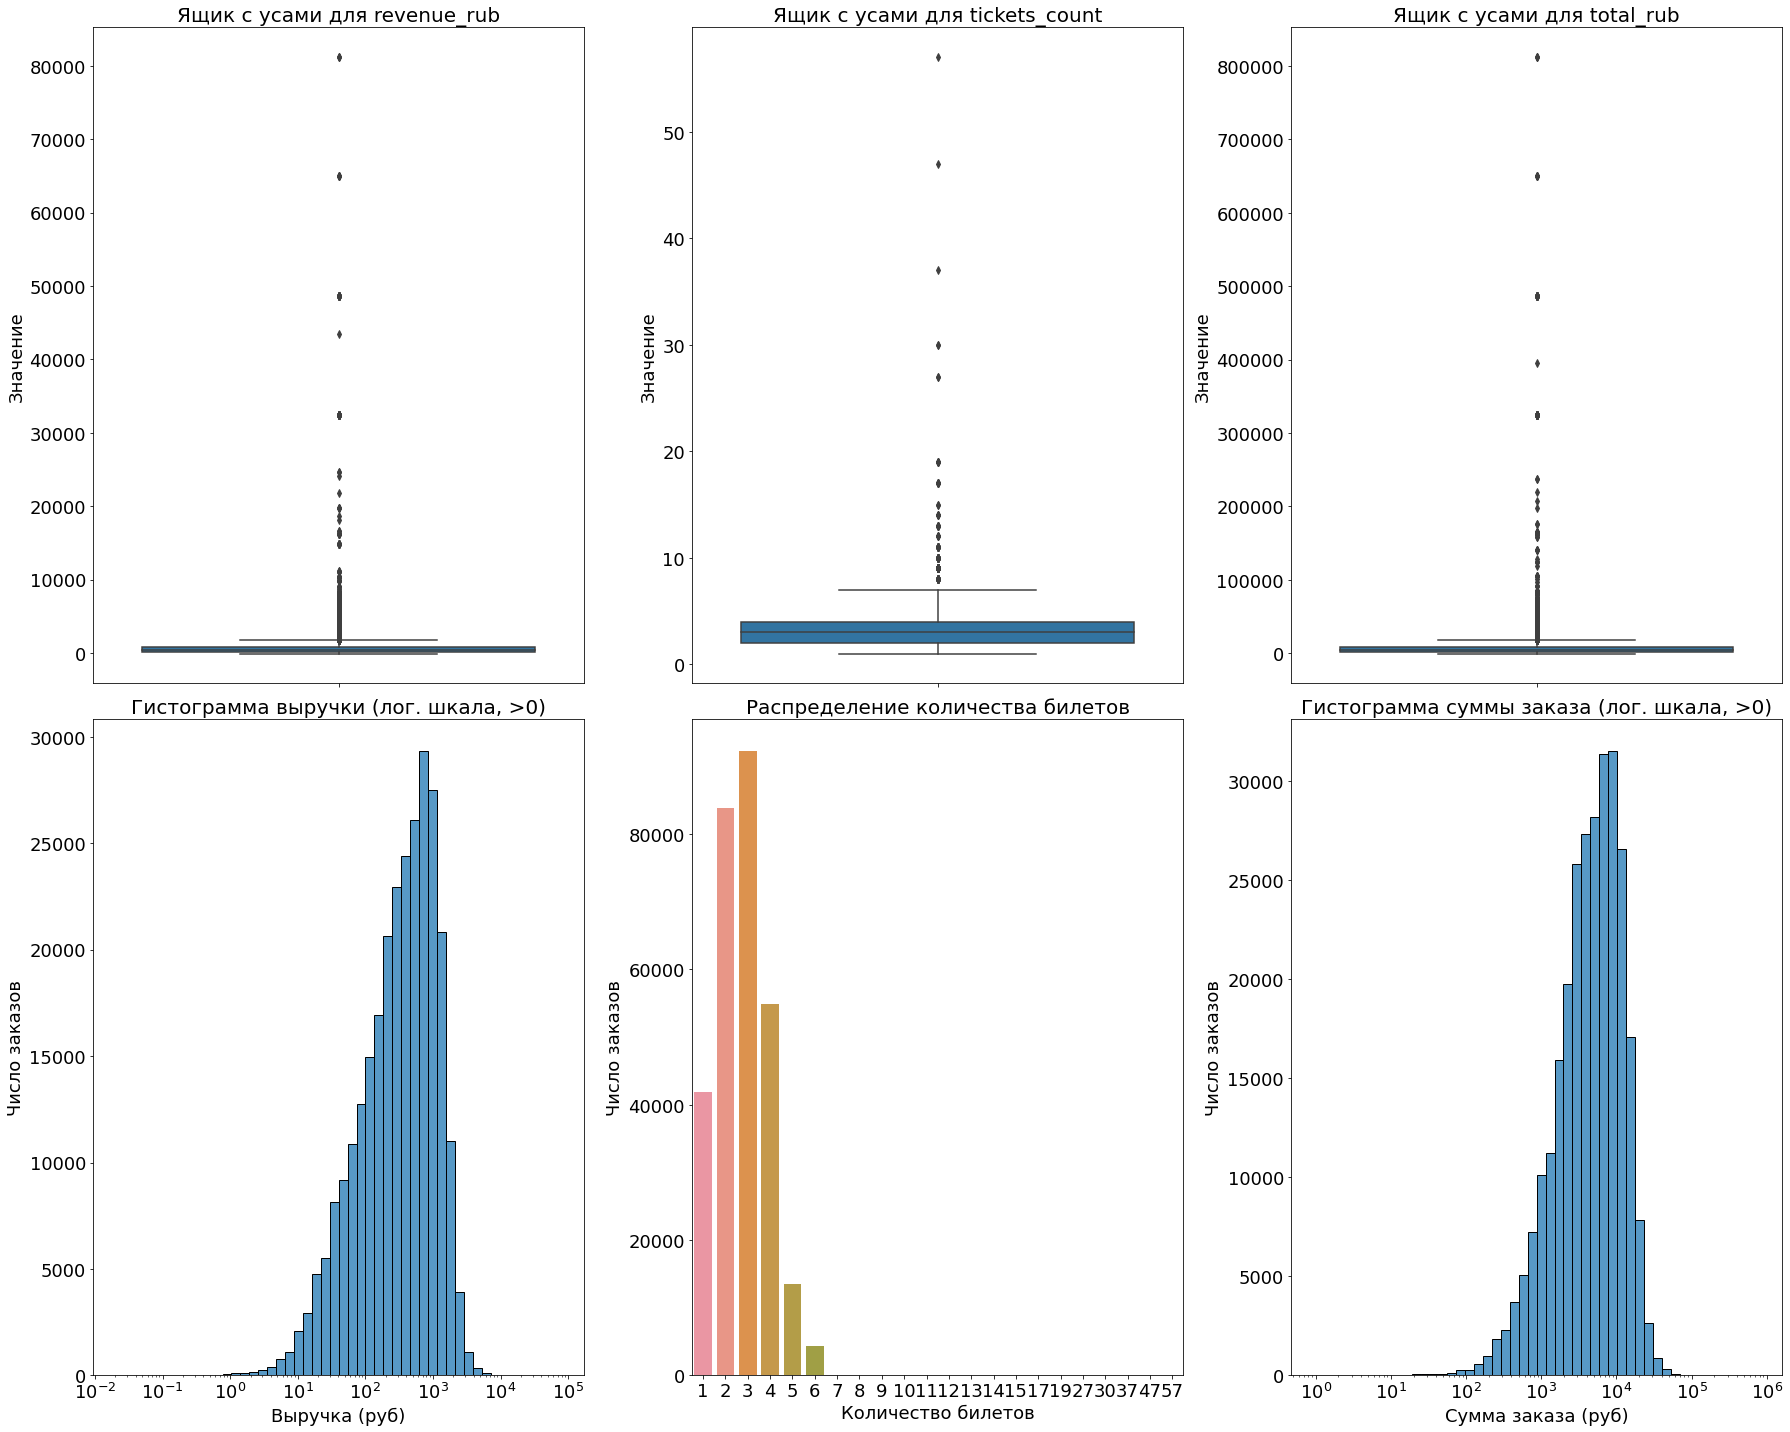

In [15]:
#анализ количественных переменных с визуализацией
print("\nУглубленный анализ количественных переменных:")
num_cols = ['revenue_rub', 'tickets_count', 'total_rub']

plt.figure(figsize=(25, 20))
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 18
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=orders[col])
    plt.title(f'Ящик с усами для {col}', fontsize=title_fontsize)
    plt.ylabel('Значение', fontsize=label_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.subplot(2, 3, i+3)
    if col == 'tickets_count':
        sns.countplot(x=orders[col])
        plt.title(f'Распределение количества билетов', fontsize=title_fontsize)
        plt.xlabel('Количество билетов', fontsize=label_fontsize)
        plt.ylabel('Число заказов', fontsize=label_fontsize)

    else:
        positive_data = orders[col][orders[col] > 0]
        sns.histplot(positive_data, bins=50, log_scale=True)
        if col == 'revenue_rub':
            plt.title(f'Гистограмма выручки (лог. шкала, >0)', fontsize=title_fontsize)
            plt.xlabel('Выручка (руб)', fontsize=label_fontsize)
        else:
            plt.title(f'Гистограмма суммы заказа (лог. шкала, >0)', fontsize=title_fontsize)
            plt.xlabel('Сумма заказа (руб)', fontsize=label_fontsize)
        plt.ylabel('Число заказов', fontsize=label_fontsize)
    
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
plt.tight_layout()
plt.show()


 Распределение количественных переменных:
 
 
 Все переменные имеют ненормальное распределение, судя по гистограммам.
 Все переменные имеют выбросы, но можно обратить внимание, что максимальный чек (811745.400000) ровно на порядок выше максимальной выручки (81174.540000), видимо в чеке ошибка. В целом все значения чека будто можно разделит на 10, чтобы привести их к верным значениям (но это не точно).
 Несмотря на это ширина гистограммы по сумме заказов уже гистограммы по выручке - это значит, что дисперсия у данных ниже.

Количество покупаемых билетов обычно колеблется от 2 до 4, но, в целом, не редки и покупки с 1, 5-6 билетами. максимальное количество купленных за раз билетов - 57.
 


In [16]:

#  анализ отрицательных значений
neg_values = orders[(orders['revenue_rub'] <= 0) | (orders['total_rub'] <= 0)].copy()
neg_values['month'] = neg_values['created_dt_msk'].dt.month

print("\nАнализ неположительных значений:")
print(f"Найдено {len(neg_values)} заказов с revenue_rub или total_rub <= 0")
if len(neg_values) > 0:
    print("\nПримеры таких заказов:")
    display(neg_values[['order_id', 'user_id', 'revenue_rub', 'total_rub', 
                       'tickets_count', 'currency_code', 'created_dt_msk']].head())
    
    # Анализ по времени возникновения
    print("\nРаспределение по датам:")
    neg_values['month'] = neg_values['created_dt_msk'].dt.month
    print(neg_values['month'].value_counts().sort_index())
    
    # Анализ по сервисам
    print("\nРаспределение по сервисам:")
    print(neg_values['service_name'].value_counts())


Анализ неположительных значений:
Найдено 6112 заказов с revenue_rub или total_rub <= 0

Примеры таких заказов:


,order_id,user_id,revenue_rub,total_rub,tickets_count,currency_code,created_dt_msk
24,3253250,0018ecd8a38a51b,0.0,0.0,3,rub,2024-07-25
68,4130442,0033403583a55ed,0.0,0.0,1,rub,2024-06-19
69,4130500,0033403583a55ed,0.0,0.0,1,rub,2024-06-19
70,4130471,0033403583a55ed,0.0,0.0,1,rub,2024-06-19
71,4130529,0033403583a55ed,0.0,0.0,1,rub,2024-06-19



Распределение по датам:
6     1441
7     2523
8     1399
9      470
10     279
Name: month, dtype: int64

Распределение по сервисам:
Билеты без проблем    5187
Билеты в руки          478
Лови билет!            297
Лучшие билеты          143
Мой билет                6
Тебе билет!              1
Name: service_name, dtype: int64


Как уже отмечалось в первой части проекта, отрицательные и нулевые выручка и чек встречается лишь в отпределенных сервисах.Возможно, это следствие неудачной рекламной компании проводимой летом. К октябрю количество таких билетов значительно снизилось.

In [17]:
# Проверка дубликатов
print("\nПроверка дубликатов:")
# Явные дубликаты (полные копии строк)
print("Полные дубликаты:", orders.duplicated().sum())




Проверка дубликатов:
Полные дубликаты: 0


In [18]:
# Выделяем потенциальные дубликаты (без учета order_id)
dup_cols = [col for col in orders.columns if col not in ['order_id']]
duplicates = orders[orders.duplicated(subset=dup_cols, keep=False)].sort_values(dup_cols)

print(f"Найдено {len(duplicates)} потенциальных дубликатов")
print("Примеры дубликатов:")
display(duplicates.head(10))

Найдено 58 потенциальных дубликатов
Примеры дубликатов:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,order_date,data,kzt_to_rub,revenue_rub,total_rub
11777,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0,2024-08-13,2024-08-13,NaN,69.82,997.48
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0,2024-08-13,2024-08-13,NaN,69.82,997.48
57217,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0,2024-10-30,2024-10-30,NaN,11.23,280.81
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0,2024-10-30,2024-10-30,NaN,11.23,280.81
84010,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0,2024-06-25,2024-06-25,NaN,59.19,739.85
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0,2024-06-25,2024-06-25,NaN,59.19,739.85
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0,2024-10-28,2024-10-28,NaN,26.96,674.12
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0,2024-10-28,2024-10-28,NaN,26.96,674.12
154170,5372628,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0,2024-08-23,2024-08-23,NaN,126.84,3170.95
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0,2024-08-23,2024-08-23,NaN,126.84,3170.95


In [19]:
orders_clean = orders.drop_duplicates(subset=dup_cols, keep='first')
print(f"Исходный размер: {orders.shape}")
print(f"После обработки: {orders_clean.shape}")
print(f"Удалено записей: {len(orders) - len(orders_clean)}")

Исходный размер: (290849, 19)
После обработки: (290819, 19)
Удалено записей: 30


In [20]:
orders=orders_clean.copy()

In [21]:
# Выделяем потенциальные дубликаты (без учета order_id)
dup_cols = ['user_id', 'created_ts_msk', 'device_type_canonical','service_name','event_id','revenue_rub', 'total_rub']
duplicates = orders[orders.duplicated(subset=dup_cols, keep=False)].sort_values(dup_cols)

print(f"Найдено {len(duplicates)} потенциальных дубликатов")
print("Примеры дубликатов:")
display(duplicates.head(10))

Найдено 28 потенциальных дубликатов
Примеры дубликатов:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,order_date,data,kzt_to_rub,revenue_rub,total_rub
26894,1930705,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,Лови билет!,3,19450.63,11.0,2024-07-31,2024-07-31,NaN,1556.05,19450.63
26896,1930763,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,Лови билет!,3,19450.63,0.0,2024-07-31,2024-07-31,NaN,1556.05,19450.63
32462,161560,110125b4a429b43,2024-06-12,2024-06-12 10:23:35,536826,нет,12,kzt,mobile,13212.93,Мой билет,3,165161.66,0.0,2024-06-12,2024-06-12,NaN,NaN,NaN
32464,161502,110125b4a429b43,2024-06-12,2024-06-12 10:23:35,536826,нет,12,kzt,mobile,17617.24,Мой билет,4,220215.55,0.0,2024-06-12,2024-06-12,NaN,NaN,NaN
53715,1935113,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,нет,16,rub,mobile,601.69,Билеты в руки,2,6016.94,32.0,2024-10-29,2024-10-29,NaN,601.69,6016.94
53717,1935171,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,нет,16,rub,mobile,601.69,Билеты в руки,2,6016.94,0.0,2024-10-29,2024-10-29,NaN,601.69,6016.94
68214,3326185,2ecf0a4e24cae13,2024-10-17,2024-10-17 15:25:33,481392,нет,18,rub,mobile,40.33,Билеты без проблем,2,1008.14,7.0,2024-10-17,2024-10-17,NaN,40.33,1008.14
68215,3326272,2ecf0a4e24cae13,2024-10-17,2024-10-17 15:25:33,481392,нет,18,rub,mobile,40.33,Билеты без проблем,2,1008.14,0.0,2024-10-17,2024-10-17,NaN,40.33,1008.14
74521,4536210,35c4c43710a1e8c,2024-09-28,2024-09-28 13:43:54,568022,нет,12,rub,mobile,1891.93,Мир касс,6,18919.32,33.0,2024-09-28,2024-09-28,NaN,1891.93,18919.32
74528,4536123,35c4c43710a1e8c,2024-09-28,2024-09-28 13:43:54,568022,нет,12,rub,mobile,1891.93,Мир касс,6,18919.32,0.0,2024-09-28,2024-09-28,NaN,1891.93,18919.32


In [22]:
orders_clean = orders.drop_duplicates(subset=dup_cols, keep='first')
print(f"Исходный размер: {orders.shape}")
print(f"После обработки: {orders_clean.shape}")
print(f"Удалено записей: {len(orders) - len(orders_clean)}")

Исходный размер: (290819, 19)
После обработки: (290805, 19)
Удалено записей: 14


In [23]:
orders=orders_clean.copy()

Было решено удалить неявные дубликаты, вероятно связанные с повторными ошибочными заказами. Взможно, при покупке билетов не прошла оплата в первый раз и пользователь создавал повторный идентичный заказ.

In [24]:
# Удаление выбросов в revenue_rub (99-й перцентиль)
revenue_threshold = orders['revenue_rub'].quantile(0.99)
orders = orders[orders['revenue_rub'] <= revenue_threshold]

In [25]:
orders = orders.drop(columns=['order_date', 'data', 'kzt_to_rub'])

In [26]:
# Выручка за билет
orders['one_ticket_revenue_rub'] = orders['revenue_rub'] / orders['tickets_count']

# День недели
orders['day_of_week'] = pd.to_datetime(orders['created_dt_msk']).dt.day_name()

In [27]:
merged_data = pd.merge(
    orders,
    events,
    on='event_id',
    how='left'
)

In [28]:
# Добавление сезонов
merged_data['month'] = pd.to_datetime(merged_data['created_dt_msk']).dt.month
merged_data['season'] = merged_data['month'].apply(
    lambda x: 'лето' if x in [6, 7, 8] else 'осень'
)

In [29]:
merged_data

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",10,осень
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282877,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,...,другое,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",10,осень
282878,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,...,другое,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",10,осень
282879,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,...,театр,№4837,Каменевский регион,Глиногорск,213.0,3470.0,"Клуб киноманов ""Верность"" Лтд","пр. Титова, д. 5 стр. 68",10,осень
282880,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,...,стендап,№998,Широковская область,Ягодиновка,239.0,2449.0,"Гильдия художников ""Флит"" Инк","пр. Макарова, д. 4",9,осень


Добавили столбцы с только рублевой валютой, удалили лишние столбцы.
Добавили столбцы с месяцем и днем недели, а также для дальнейшего анализа.
Рассчитали выручку за один билет

In [30]:
# Исходные данные
initial_count = len(orders)
initial_columns = orders.shape[1]

# После обработки
final_count = len(merged_data)
final_columns = merged_data.shape[1]

# потери
lost_records = initial_count - final_count
lost_percentage = (lost_records / initial_count) * 100

print(f"Исходное количество записей: {initial_count}")
print(f"Конечное количество записей: {final_count}")
print(f"Потеряно записей: {lost_records} ({lost_percentage:.2f}%)")
print(f"\nИсходное количество столбцов: {initial_columns}")
print(f"Конечное количество столбцов: {final_columns}")
print(f"Добавлено столбцов: {final_columns - initial_columns}")

Исходное количество записей: 282882
Конечное количество записей: 282882
Потеряно записей: 0 (0.00%)

Исходное количество столбцов: 18
Конечное количество столбцов: 30
Добавлено столбцов: 12


In [31]:
# Проверка пропусков в объединенном датафрейме
print("\nПропуски в объединенном датафрейме:")
missing_data = merged_data.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) == 0:
    print("Пропуски отсутствуют")
else:
    print(missing_data)
    



Пропуски в объединенном датафрейме:
days_since_prev           20872
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64


In [32]:
missing_events = merged_data[merged_data['event_name'].isnull()]
# Проверка уникальных event_id с пропусками
print("\nУникальные event_id с пропущенной информацией:")
print(missing_events['event_id'].unique())

# Проверка временного распределения этих event_id
missing_events_dates = missing_events['created_dt_msk'].dt.date.value_counts()
print("\nДаты заказов с пропущенными мероприятиями:")
print(missing_events_dates.head(10))


Уникальные event_id с пропущенной информацией:
[533222 530296 532300 477731 536716 246804 536731 555671 548224 538260
 534151 536715 539336 553041 553435 548062 572020 559840 505937]

Даты заказов с пропущенными мероприятиями:
2024-06-05    31
2024-06-08    27
2024-06-22    19
2024-06-07    18
2024-06-09    12
2024-06-12    12
2024-06-14    11
2024-08-06    10
2024-06-13     8
2024-06-04     7
Name: created_dt_msk, dtype: int64


In [33]:
missing_data

days_since_prev           20872
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
dtype: int64

In [34]:
# Получаем уникальные event_id из исходных датафреймов
events_ids = set(events['event_id'].unique())
orders_ids = set(orders['event_id'].unique())

missing_in_orders = list(events_ids - orders_ids)
print(f"Количество event_id из справочника мероприятий, отсутствующих в заказах: {len(missing_in_orders)}")
print("Примеры 20 таких event_id:", missing_in_orders[:20])

missing_in_events = list(orders_ids - events_ids)
print(f"\nКоличество event_id из заказов, отсутствующих в справочнике мероприятий: {len(missing_in_events)}")
print("Примеры 20 таких event_id:", missing_in_events[:20])

# Полный список расхождений
if len(missing_in_orders) > 0:
    pd.DataFrame({'event_id_only_in_events': missing_in_orders}).to_csv('events_only_in_events.csv', index=False)
    
if len(missing_in_events) > 0:
    pd.DataFrame({'event_id_only_in_orders': missing_in_events}).to_csv('events_only_in_orders.csv', index=False)

print(f"\nОбщее количество уникальных event_id в заказах: {len(orders_ids)}")
print(f"Общее количество уникальных event_id в справочнике: {len(events_ids)}")
print(f"Количество совпадающих event_id: {len(events_ids & orders_ids)}")

Количество event_id из справочника мероприятий, отсутствующих в заказах: 151
Примеры 20 таких event_id: [516611, 551942, 559625, 585226, 547853, 155150, 580114, 580115, 580117, 529430, 547863, 580118, 580119, 566820, 582697, 525355, 579640, 538682, 543806, 538690]

Количество event_id из заказов, отсутствующих в справочнике мероприятий: 19
Примеры 20 таких event_id: [548224, 534151, 536715, 536716, 538260, 246804, 555671, 536731, 477731, 539336, 532300, 553041, 505937, 553435, 548062, 559840, 533222, 572020, 530296]

Общее количество уникальных event_id в заказах: 22295
Общее количество уникальных event_id в справочнике: 22427
Количество совпадающих event_id: 22276


Судя по всему данные не потеряны при объединении, данных по этим мероприятиям изначально не было в датафрейме events

В результате подготовки данных, был создан обобщенный датафрейм с переведенными выручкой и чеком в рубли. Перед созданием итоговой таблицы исходные данные были проверены на наличие пропусков, дубликатов. Были проверены категориальные данные, а также  даты приведены в формат "даты".
Также был проведен статистический анализ данных, из данных были убраны аномалии по выручке.

<a class='anchor' id="ch3"></a>
## 3. Исследовательский анализ данных

### Анализ динамики метрик

In [35]:
merged_data

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",10,осень
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282877,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,...,другое,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",10,осень
282878,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,...,другое,№1823,Каменевский регион,Глиногорск,213.0,3952.0,"Творческое объединение ""Модуль"" Инкорпорэйтед","алл. Глинки, д. 9/8 к. 67",10,осень
282879,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,...,театр,№4837,Каменевский регион,Глиногорск,213.0,3470.0,"Клуб киноманов ""Верность"" Лтд","пр. Титова, д. 5 стр. 68",10,осень
282880,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,...,стендап,№998,Широковская область,Ягодиновка,239.0,2449.0,"Гильдия художников ""Флит"" Инк","пр. Макарова, д. 4",9,осень


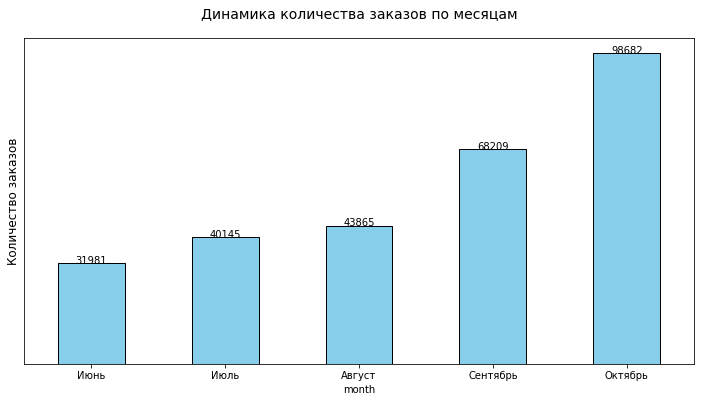

In [36]:

# Динамика заказов по месяцам
plt.figure(figsize=(12, 6))
ax = merged_data.groupby('month')['order_id'].count().plot(kind='bar', color='skyblue', edgecolor='black')

# Добавляем значения над столбцами
for i, v in enumerate(merged_data.groupby('month')['order_id'].count()):
    ax.text(i, v + 10, str(v), ha='center', fontsize=10)

plt.ylabel('Количество заказов', fontsize=12)
plt.title('Динамика количества заказов по месяцам', fontsize=14, pad=20)
plt.yticks([])
month_names = ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь']
plt.xticks(range(len(month_names)), month_names, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


По графику действительно наблюдается резкий скачок количества заказов с начала осени.

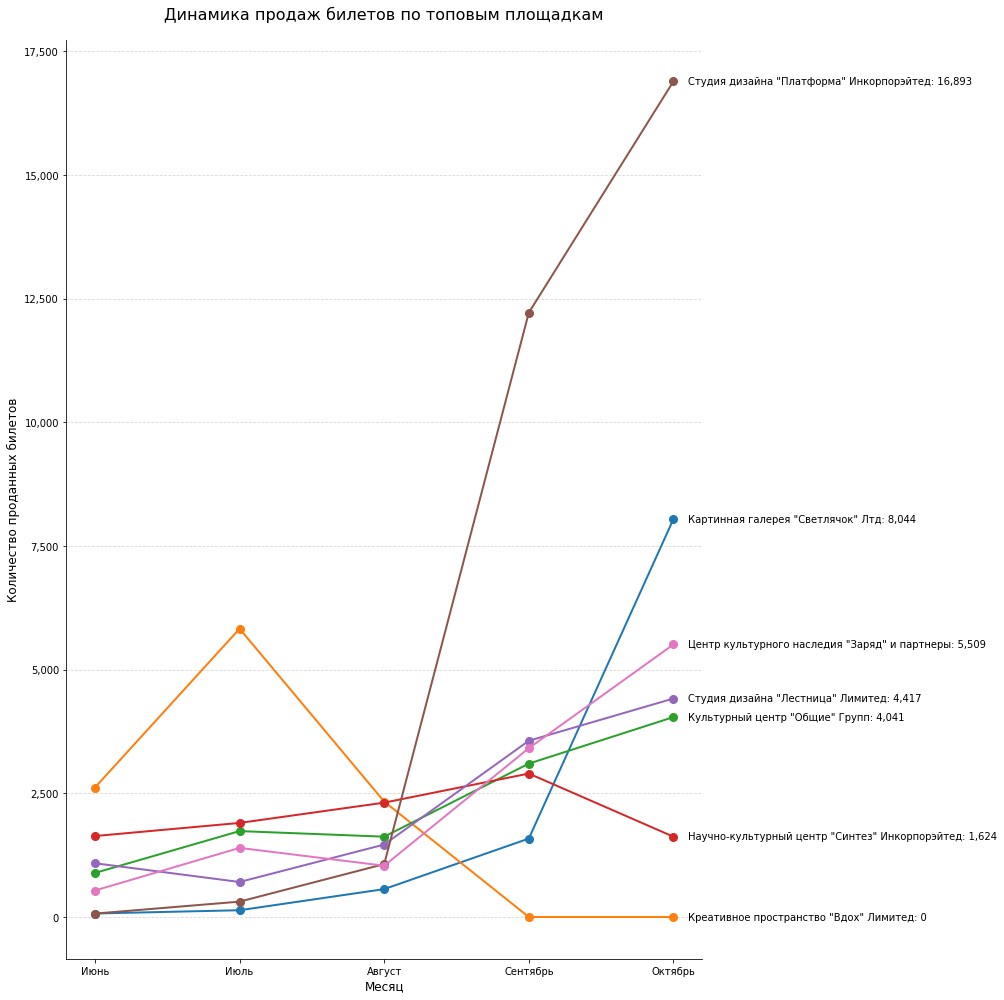

In [37]:
# Определяем топ-7 площадок по общему количеству билетов
top_venues = merged_data.groupby('venue_name')['tickets_count'].sum().nlargest(7).index
filtered_data = merged_data[merged_data['venue_name'].isin(top_venues)].copy()
month_order = ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь']
filtered_data['month_name'] = pd.Categorical(
    filtered_data['month'].map({
        6: 'Июнь',
        7: 'Июль',
        8: 'Август',
        9: 'Сентябрь',
        10: 'Октябрь'
    }),
    categories=month_order,
    ordered=True
)

tickets_by_venue_month = filtered_data.groupby(['venue_name', 'month_name'])['tickets_count'].sum().unstack()
plt.figure(figsize=(14, 14))
for venue in tickets_by_venue_month.index:
    plt.plot(tickets_by_venue_month.columns, 
             tickets_by_venue_month.loc[venue],
             marker='o',
             linewidth=2,
             markersize=8,
             label=venue)

plt.title('Динамика продаж билетов по топовым площадкам', fontsize=16, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество проданных билетов', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for venue in tickets_by_venue_month.index:
    last_value = tickets_by_venue_month.loc[venue].iloc[-1]
    plt.text(4.1, last_value, f'{venue}: {last_value:,}', 
             va='center', fontsize=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

В динамике продаж довольно неплохо поднялось несколько площадок - Студия дизайна "Платформа" Инкорпорейтед (с 0 до 16 893 билетов) и Картинная галерея светлячок (с 0 до 8 044). 
А вот Креативное пространство "Вдох" лимитед, видимо превысило свой лимит по вдохам и успешно задохнулось в сентябре.

#### 3.1.1. Анализ мероприятий

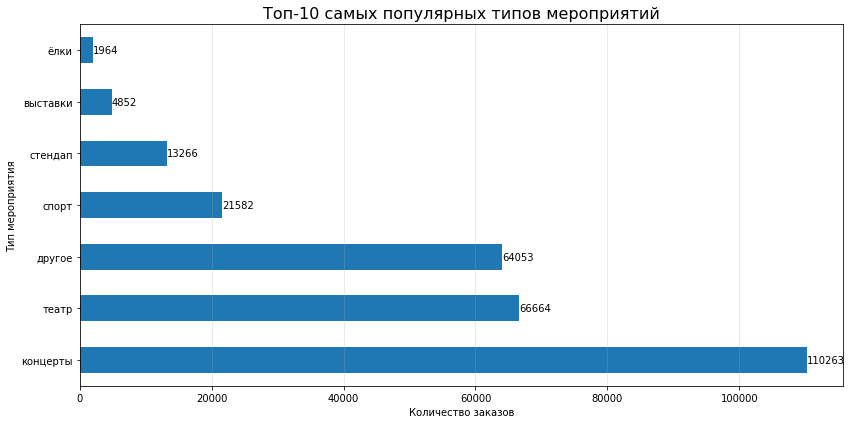

In [38]:
# Анализ популярности мероприятий (топ-10 по количеству заказов)
plt.figure(figsize=(12, 6))
top_events = merged_data['event_type_main'].value_counts().nlargest(10)
ax = top_events.plot(kind='barh', color='#1f77b4')
plt.title('Топ-10 самых популярных типов мероприятий', fontsize=16)
plt.xlabel('Количество заказов')
plt.ylabel('Тип мероприятия')
plt.grid(axis='x', alpha=0.3)

# Добавляем подписи значений
for i, v in enumerate(top_events):
    ax.text(v + 20, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()


Наиболее популярное мероприятие - концерты, за все время исследования было приобретено 110 263 билетов.
Далее идут театры, они занимают гордое второе место, с количеством заказов - 66 664 (практически в два раза меньше, ну чтож)
Не совсем понятно насколько корректно в данном рейтинге рассматривать "другое" т.к. это то же самое как сложить несколько категорий в одну, но тем не менее пок количеству проданных билетов, данная категория занимает третье место (64 053).

<Figure size 1008x576 with 0 Axes>

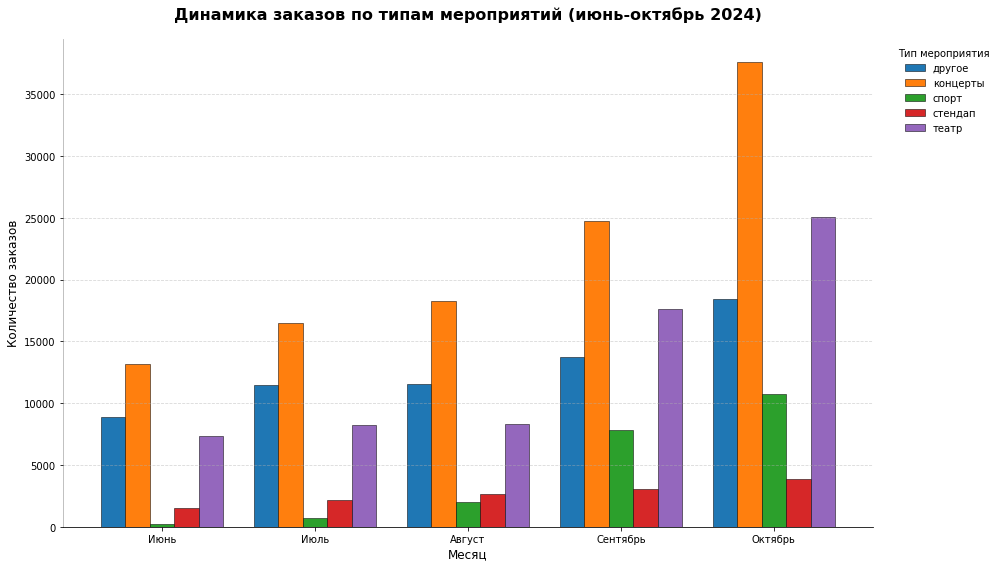

In [39]:
#Анализ данных в разрезе типа мероприятия по месяцам
# Получаем топ-5 самых популярных типов мероприятий
top_events = merged_data['event_type_main'].value_counts().nlargest(5).index
filtered_data = merged_data[merged_data['event_type_main'].isin(top_events)].copy()

# Создаем категориальный тип для сохранения порядка месяцев
month_names = ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь']
filtered_data['month_name'] = pd.Categorical(
    filtered_data['month'].map({
        6: 'Июнь',
        7: 'Июль',
        8: 'Август',
        9: 'Сентябрь',
        10: 'Октябрь'
    }),
    categories=month_names,
    ordered=True
)
grouped_data = filtered_data.groupby(['month_name', 'event_type_main'])['order_id'].count().unstack()


plt.figure(figsize=(14, 8))
ax = grouped_data.plot(
    kind='bar',
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],  # Кастомная цветовая схема
    edgecolor='black',
    linewidth=0.5,
    figsize=(14, 8)
)

plt.title('Динамика заказов по типам мероприятий (июнь-октябрь 2024)', 
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.3)
plt.legend(title='Тип мероприятия', 
           bbox_to_anchor=(1.02, 1),
           loc='upper left',
           frameon=False)

plt.tight_layout()
plt.show()

В целом, осенью наблюдается скачок по всем мероприятиям. Наиболее незначительные изменения наблюдаются в стендапе. В целом, относительно плавный рост наблюдается у группы "другое". Значительный скачок в покупках наблюдается в категории спорт, далее в театрах и концертах.

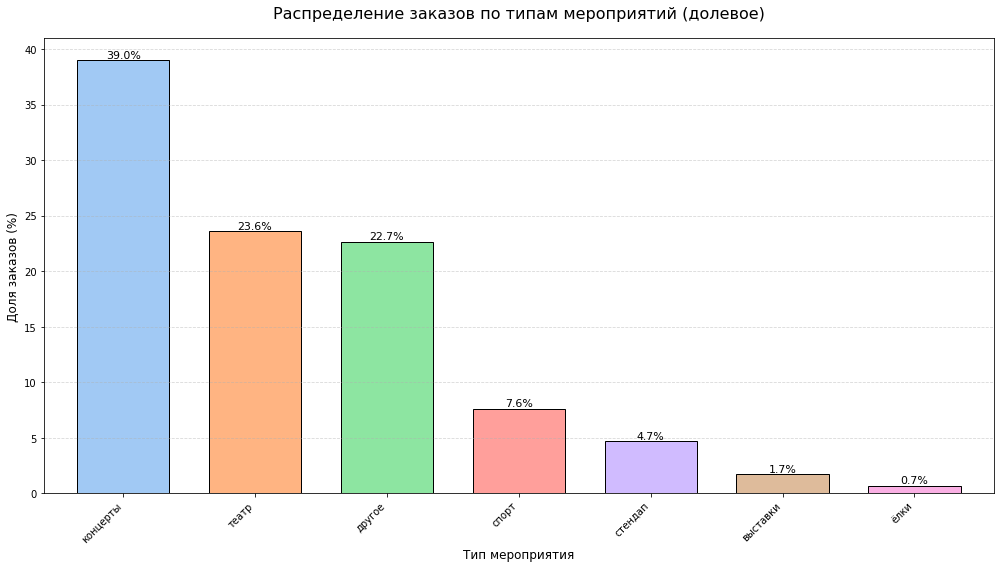

In [40]:
plt.figure(figsize=(14, 8))


event_type_share = merged_data['event_type_main'].value_counts(normalize=True).mul(100).sort_values(ascending=False)

ax = event_type_share.plot(
    kind='bar',
    color=sns.color_palette('pastel'),
    edgecolor='black',
    width=0.7
)
plt.title('Распределение заказов по типам мероприятий (долевое)', fontsize=16, pad=20)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Доля заказов (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=11)

plt.tight_layout()
plt.show()

Наибольшая доля заказов по мероприятиям, ожидаемо, приходится на концерты - 39%, второе место - театры (23.6%), тройку лидеров завершает категория "другое" - 22.7%.

<Figure size 1008x576 with 0 Axes>

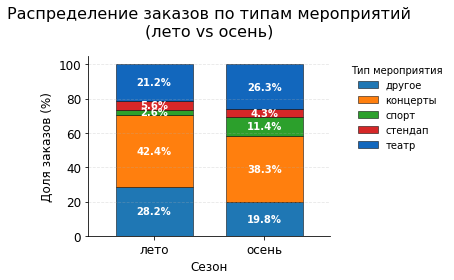

In [41]:
# Рассчитываем доли заказов по сезонам
event_season_share = (
    filtered_data.groupby(['season', 'event_type_main'])['order_id']
    .count()
    .unstack()
    .apply(lambda x: x/x.sum()*100, axis=1)
)


plt.figure(figsize=(14, 8))
ax = event_season_share.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#1267bd', '#9467bd'],
    edgecolor='black',
    linewidth=0.5
)

plt.title('Распределение заказов по типам мероприятий\n(лето vs осень)', 
          fontsize=16, pad=20)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Доля заказов (%)', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

for i, season in enumerate(event_season_share.index):
    bottom = 0
    for j, event_type in enumerate(event_season_share.columns):
        value = event_season_share.loc[season, event_type]
        if value > 1:  # Подписываем только значимые доли (>1%)
            ax.text(
                x=i, 
                y=bottom + value/2, 
                s=f'{value:.1f}%', 
                ha='center', 
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )
        bottom += value

plt.legend(
    title='Тип мероприятия',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()

<Figure size 1008x1008 with 0 Axes>

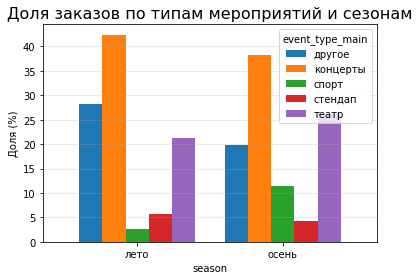

In [42]:
plt.figure(figsize=(14, 14))
event_season_share.plot(kind='bar', width=0.8)
plt.title('Доля заказов по типам мероприятий и сезонам', fontsize=16)
plt.ylabel('Доля (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [43]:
event_analysis = merged_data.groupby(['season', 'event_type_main']).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'revenue_rub': 'sum',
    'tickets_count': 'sum'
}).rename(columns={
    'order_id': 'Всего заказов',
    'user_id': 'Уникальные пользователи',
    'revenue_rub': 'Общая выручка',
    'tickets_count': 'Всего билетов'
})


event_analysis['Средний чек'] = event_analysis['Общая выручка'] / event_analysis['Всего заказов']
event_analysis['Билетов на заказ'] = event_analysis['Всего билетов'] / event_analysis['Всего заказов']
event_analysis['Заказов на пользователя'] = event_analysis['Всего заказов'] / event_analysis['Уникальные пользователи']

# Расчет долей ВНУТРИ каждого сезона
event_analysis['Доля заказов'] = (event_analysis.groupby('season')['Всего заказов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

event_analysis['Доля пользователей'] = (event_analysis.groupby('season')['Уникальные пользователи']
                                       .transform(lambda x: x / x.sum())
                                       .apply(lambda x: f"{x:.1%}"))

event_analysis['Доля выручки'] = (event_analysis.groupby('season')['Общая выручка']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

event_analysis['Доля билетов'] = (event_analysis.groupby('season')['Всего билетов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

print("Анализ мероприятий по сезонам:")
display(event_analysis)

Анализ мероприятий по сезонам:


Всего заказов  Уникальные пользователи  Общая выручка  \
season event_type_main                                                          
лето   выставки                  2416                      944      551770.12   
       другое                   31900                     5541     7321930.42   
       концерты                 47944                     7821    36412906.32   
       спорт                     2968                      838      434027.20   
       стендап                   6343                     1886     4097769.12   
       театр                    23931                     4279    13997456.86   
       ёлки                       273                      148      220285.44   
осень  выставки                  2436                      937      574873.75   
       другое                   32153                     5696     7405914.68   
       концерты                 62319                     8939    43842476.72   
       спорт                    18614                     2041     2837997.30   
       стендап                   6923                     2050     4691238.24   
       театр                    42733                     6155    20633547.53   
       ёлки                      1691                      623     1240464.97   

                        Всего билетов  Средний чек  Билетов на заказ  \
season event_type_main                                                 
лето   выставки                  6172   228.381672          2.554636   
       другое                   88608   229.527599          2.777680   
       концерты                126773   759.488285          2.644189   
       спорт                     8632   146.235580          2.908356   
       стендап                  19044   646.030131          3.002365   
       театр                    66205   584.908982          2.766495   
       ёлки                       836   806.906374          3.062271   
осень  выставки                  6232   235.990866          2.558292   
       другое                   88017   230.333551          2.737443   
       концерты                163404   703.517013          2.622057   
       спорт                    57261   152.465741          3.076233   
       стендап                  20515   677.630831          2.963311   
       театр                   117000   482.848092          2.737931   
       ёлки                      5691   733.568876          3.365464   

                        Заказов на пользователя Доля заказов  \
season event_type_main                                         
лето   выставки                        2.559322         2.1%   
       другое                          5.757084        27.6%   
       концерты                        6.130162        41.4%   
       спорт                           3.541766         2.6%   
       стендап                         3.363203         5.5%   
       театр                           5.592662        20.7%   
       ёлки                            1.844595         0.2%   
осень  выставки                        2.599787         1.5%   
       другое                          5.644838        19.3%   
       концерты                        6.971585        37.3%   
       спорт                           9.120039        11.2%   
       стендап                         3.377073         4.1%   
       театр                           6.942811        25.6%   
       ёлки                            2.714286         1.0%   

                       Доля пользователей Доля выручки Доля билетов  
season event_type_main                                               
лето   выставки                      4.4%         0.9%         2.0%  
       другое                       25.8%        11.6%        28.0%  
       концерты                     36.4%        57.8%        40.1%  
       спорт                         3.9%         0.7%         2.7%  
       стендап                       8.8%         6.5%         6.0%  
       театр                        19.9%        22.2%     

В долевом распределении мероприятий по сезонам наблюдается следеющее:
Значительный рост спроса на спортивные мероприятия осенью (11.2% от всех мероприятий против 2.6% летом) и на театр (25.6% против 20.7%), наблюдается спад спроса на концерты (37.3% осенью против 41.4% летом), а также на категорию "другое" (19.3% против 27.6%). Спад спроса также наблюдается в категории "стендап" - 7.8% против 8.8%, что для данной категории значительно. Аналогичный вывод можно сделать и по категории "выставки" - 2.1% против 1.5%.
Несмотря на вышесказанное львиная доля выручки все также приходится на концерты (54%), на втором месте театры (25.4%)

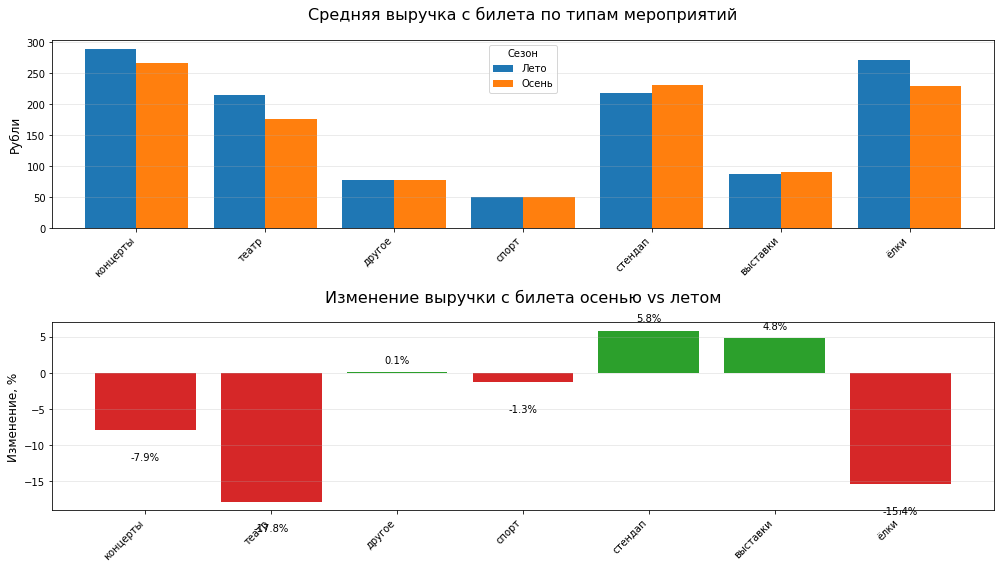

season,Лето,Осень,"Изменение, %"
стендап,218 руб.,231 руб.,5.8%
выставки,86 руб.,91 руб.,4.8%
другое,78 руб.,78 руб.,0.1%
спорт,50 руб.,50 руб.,-1.3%
концерты,290 руб.,267 руб.,-7.9%
ёлки,271 руб.,230 руб.,-15.4%
театр,214 руб.,176 руб.,-17.8%


In [44]:

merged_data['revenue_per_ticket'] = merged_data['revenue_rub'] / merged_data['tickets_count']
merged_data['season'] = merged_data['month'].apply(lambda x: 'Лето' if x in [6,7,8] else 'Осень')
seasonal_revenue = merged_data.groupby(['event_type_main', 'season'])['revenue_per_ticket'].mean().unstack()
seasonal_revenue['Изменение, %'] = ((seasonal_revenue['Осень'] - seasonal_revenue['Лето']) / seasonal_revenue['Лето'] * 100).round(1)

# Выбор топ-10 мероприятий по объему продаж
top_events = merged_data['event_type_main'].value_counts().nlargest(10).index
seasonal_revenue = seasonal_revenue.loc[top_events]


plt.figure(figsize=(14, 8))

# График средних значений
ax1 = plt.subplot(2, 1, 1)
seasonal_revenue[['Лето', 'Осень']].plot(kind='bar', 
                                       width=0.8,
                                       color=['#1f77b4', '#ff7f0e'],
                                       ax=ax1)
plt.title('Средняя выручка с билета по типам мероприятий', fontsize=16, pad=20)
plt.ylabel('Рубли', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Сезон')

# График изменений
ax2 = plt.subplot(2, 1, 2)
bars = plt.bar(seasonal_revenue.index, 
              seasonal_revenue['Изменение, %'],
              color=np.where(seasonal_revenue['Изменение, %'] >= 0, '#2ca02c', '#d62728'))

plt.title('Изменение выручки с билета осенью vs летом', fontsize=16, pad=20)
plt.ylabel('Изменение, %', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + (1 if height >=0 else -3),
             f'{height}%',
             ha='center', 
             va='bottom' if height >=0 else 'top',
             fontsize=10)

plt.tight_layout()
plt.show()

# таблица с результатами
display(seasonal_revenue.sort_values('Изменение, %', ascending=False).style\
    .format({'Лето': '{:.0f} руб.', 'Осень': '{:.0f} руб.', 'Изменение, %': '{:.1f}%'})\
    .background_gradient(cmap='RdYlGn', subset=['Изменение, %'])\
    .set_caption('Динамика средней выручки с билета по типам мероприятий'))

Средняя выручка не сильно изменилась в период лето/осень, но зачастую в выручке наблюдается спад.Рост выручки наблюдается по двум категориям - стендап(5.8 %) и выставки (4.8 %).
Примечательно, что несмотря на потерю в количестве аудитории стендап, другое и выставки увеличили выручку.
А вот мероприятия типа елки и театры просели в выручке на 15.4% и 17.8% соотвтетственно.



Пы.Сы. Интересно, что значит категория "Елки" летом.

#### 3.1.2. Анализ возрастных лимитов

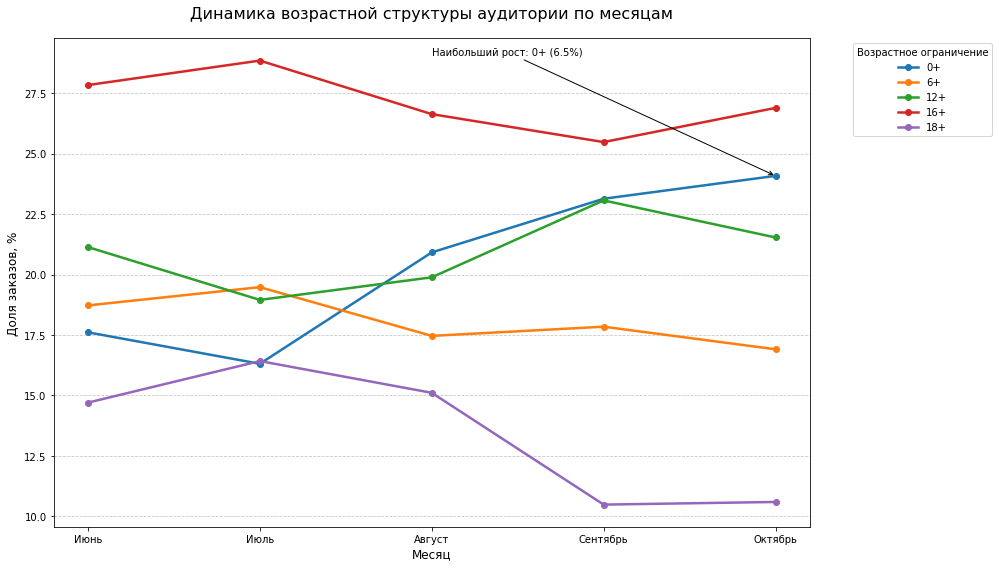

<Figure size 1008x432 with 0 Axes>

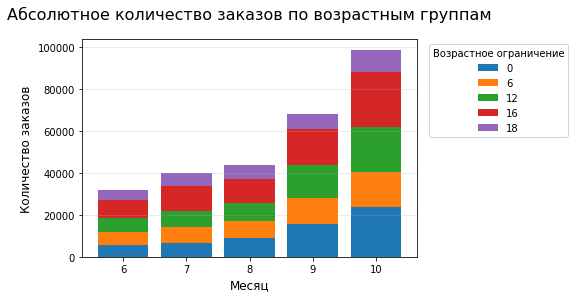

In [45]:
age_data = merged_data.groupby(['month', 'age_limit'])['order_id'].count().unstack()

# Нормализуем данные для сравнения долей
age_percent = age_data.div(age_data.sum(axis=1), axis=0) * 100


plt.figure(figsize=(14, 8))

for age_group in age_percent.columns:
    plt.plot(age_percent.index, age_percent[age_group], 
             marker='o', 
             label=f'{age_group}+',
             linewidth=2.5)

plt.title('Динамика возрастной структуры аудитории по месяцам', fontsize=16, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Доля заказов, %', fontsize=12)
plt.xticks([6,7,8,9,10], ['Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Возрастное ограничение', bbox_to_anchor=(1.05, 1), loc='upper left')

max_diff_age = (age_percent.loc[10] - age_percent.loc[6]).idxmax()
max_diff = (age_percent.loc[10] - age_percent.loc[6]).max()
plt.annotate(f'Наибольший рост: {max_diff_age}+ ({max_diff:.1f}%)', 
             xy=(10, age_percent.loc[10, max_diff_age]),
             xytext=(8, age_percent.loc[10, max_diff_age] + 5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# Дополнительный анализ: абсолютные значения
plt.figure(figsize=(14, 6))
age_data.plot(kind='bar', stacked=True, width=0.8)
plt.title('Абсолютное количество заказов по возрастным группам', fontsize=16, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Возрастное ограничение', bbox_to_anchor=(1.02, 1))
plt.grid(axis='y', alpha=0.3)
plt.show()



В данных явно наблюдается изменение спросса на билеты в разрезе возраста аудитории. В осенний период наблюдается значительный рост спроса на семейные ( без возрастных ограничений) и мероприятия с ограничением в 12+. Видимо это связано с возвращением с летних каникул школьников.

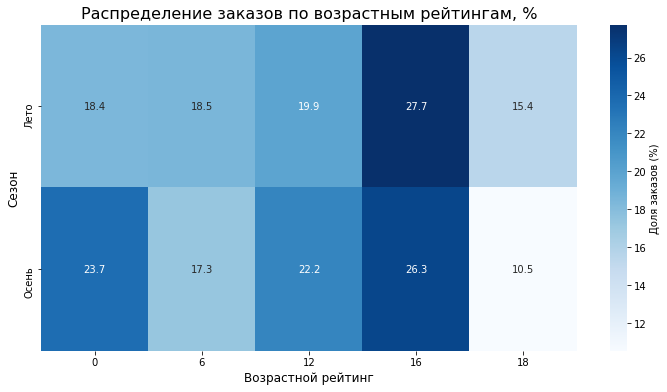

In [46]:
# Группировка по сезону и возрастному лимиту
age_season = (
    merged_data.groupby(['season', 'age_limit'])['order_id']
    .count()
    .unstack()
    .apply(lambda x: x/x.sum()*100, axis=1)
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    age_season, 
    annot=True, 
    fmt='.1f', 
    cmap='Blues',
    cbar_kws={'label': 'Доля заказов (%)'}
)
plt.title('Распределение заказов по возрастным рейтингам, %', fontsize=16)
plt.xlabel('Возрастной рейтинг', fontsize=12)
plt.ylabel('Сезон', fontsize=12)
plt.show()

Как уже отмечалось ранее, летом наблюдается больший спрос на билеты категорий от 16+, а осенью, видимо, появляется спрос на мероприятий направленные на детсткую и подростковую аудиторию.
И осенью и летом наиболее распространенная категория - 16+.

In [47]:

age_analysis = merged_data.groupby(['season', 'age_limit']).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'revenue_rub': 'sum',
    'tickets_count': 'sum'
}).rename(columns={
    'order_id': 'Всего заказов',
    'user_id': 'Уникальные пользователи',
    'revenue_rub': 'Общая выручка',
    'tickets_count': 'Всего билетов'
})


age_analysis['Средний чек'] = age_analysis['Общая выручка'] / age_analysis['Всего заказов']
age_analysis['Билетов на заказ'] = age_analysis['Всего билетов'] / age_analysis['Всего заказов']
age_analysis['Заказов на пользователя'] = age_analysis['Всего заказов'] / age_analysis['Уникальные пользователи']

age_analysis['Доля заказов'] = (age_analysis.groupby('season')['Всего заказов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

age_analysis['Доля пользователей'] = (age_analysis.groupby('season')['Уникальные пользователи']
                                       .transform(lambda x: x / x.sum())
                                       .apply(lambda x: f"{x:.1%}"))

age_analysis['Доля выручки'] = (age_analysis.groupby('season')['Общая выручка']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

age_analysis['Доля билетов'] = (age_analysis.groupby('season')['Всего билетов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))


print("Сравнение активности по возрастным лимитам:")
display(age_analysis)

Сравнение активности по возрастным лимитам:


Всего заказов  Уникальные пользователи  Общая выручка  \
season age_limit                                                          
Лето   0                  21351                     4274     5969947.61   
       6                  21465                     4346    12425687.03   
       12                 23088                     4584    15667265.29   
       16                 32169                     5858    19073644.52   
       18                 17918                     3876     9901971.44   
Осень  0                  39543                     5373     9052338.61   
       6                  28852                     5257    15061152.63   
       12                 36981                     6000    20909968.75   
       16                 43918                     6844    25517422.32   
       18                 17597                     4032    10686345.28   

                  Всего билетов  Средний чек  Билетов на заказ  \
season age_limit                                                 
Лето   0                  63014   279.609742          2.951337   
       6                  59139   578.881297          2.755136   
       12                 62407   678.589106          2.703006   
       16                 81733   592.920032          2.540738   
       18                 50560   552.627048          2.821743   
Осень  0                 117594   228.923921          2.973826   
       6                  81269   522.014163          2.816754   
       12                 98453   565.424644          2.662259   
       16                111194   581.024234          2.531855   
       18                 49659   607.282223          2.822015   

                  Заказов на пользователя Доля заказов Доля пользователей  \
season age_limit                                                            
Лето   0                         4.995555        18.4%              18.6%   
       6                         4.939024        18.5%              18.9%   
       12                        5.036649        19.9%              20.0%   
       16                        5.491465        27.7%              25.5%   
       18                        4.622807        15.4%              16.9%   
Осень  0                         7.359576        23.7%              19.5%   
       6                         5.488301        17.3%              19.1%   
       12                        6.163500        22.2%              21.8%   
       16                        6.417008        26.3%              24.9%   
       18                        4.364335        10.5%              14.7%   

                 Доля выручки Доля билетов  
season age_limit                            
Лето   0                 9.5%        19.9%  
       6                19.7%        18.7%  
       12               24.9%        19.7%  
       16               30.3%        25.8%  
       18               15.7%        16.0%  
Осень  0                11.1%        25.7%  
       6                18.5%        17.7%  
       12               25.7%        21.5%  
       16               31.4%        24.3%  
       18               13.2%        10.8%

Из интересного:
Несмотря на весомую долю проданных билетов в категории "без ограничений" выруски она приносит меньше всего. Наибольшая стоимость билетов в зависимости от сезона приходится на категории 12,16 и 18+.

#### 3.1.3. Анализ мобильных и десктопных устройств

In [48]:

device_analysis = merged_data.groupby(['season', 'device_type_canonical']).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'revenue_rub': 'sum',
    'tickets_count': 'sum'
}).rename(columns={
    'order_id': 'Всего заказов',
    'user_id': 'Уникальные пользователи',
    'revenue_rub': 'Общая выручка',
    'tickets_count': 'Всего билетов'
})


device_analysis['Средний чек'] = device_analysis['Общая выручка'] / device_analysis['Всего заказов']
device_analysis['Билетов на заказ'] = device_analysis['Всего билетов'] / device_analysis['Всего заказов']
device_analysis['Заказов на пользователя'] = device_analysis['Всего заказов'] / device_analysis['Уникальные пользователи']

device_analysis['Доля заказов'] = (device_analysis.groupby('season')['Всего заказов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

device_analysis['Доля пользователей'] = (device_analysis.groupby('season')['Уникальные пользователи']
                                       .transform(lambda x: x / x.sum())
                                       .apply(lambda x: f"{x:.1%}"))

device_analysis['Доля выручки'] = (device_analysis.groupby('season')['Общая выручка']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

device_analysis['Доля билетов'] = (device_analysis.groupby('season')['Всего билетов']
                                 .transform(lambda x: x / x.sum())
                                 .apply(lambda x: f"{x:.1%}"))

print("Сравнение активности по возрастным лимитам:")
display(device_analysis)

Сравнение активности по возрастным лимитам:


Всего заказов  Уникальные пользователи  \
season device_type_canonical                                           
Лето   desktop                        22017                     4030   
       mobile                         93974                    11677   
Осень  desktop                        33995                     4785   
       mobile                        132896                    13873   

                              Общая выручка  Всего билетов  Средний чек  \
season device_type_canonical                                              
Лето   desktop                 1.262130e+07          61319   573.252652   
       mobile                  5.041721e+07         255534   536.501716   
Осень  desktop                 1.662543e+07          98318   489.055188   
       mobile                  6.460180e+07         359851   486.107907   

                              Билетов на заказ  Заказов на пользователя  \
season device_type_canonical                                              
Лето   desktop                        2.785075                 5.463275   
       mobile                         2.719199                 8.047786   
Осень  desktop                        2.892131                 7.104493   
       mobile                         2.707764                 9.579471   

                             Доля заказов Доля пользователей Доля выручки  \
season device_type_canonical                                                
Лето   desktop                      19.0%              25.7%        20.0%   
       mobile                       81.0%              74.3%        80.0%   
Осень  desktop                      20.4%              25.6%        20.5%   
       mobile                       79.6%              74.4%        79.5%   

                             Доля билетов  
season device_type_canonical               
Лето   desktop                      19.4%  
       mobile                       80.6%  
Осень  desktop                      21.5%  
       mobile                       78.5%

Мобильная версия явно пользуется большей популярностью (34-40% в зависимости от сезона). Из интересного средний чек при покупке с компьютера будет повыше, чем с мобильной версии, хотя к осени эти показатели практически сравнялись. Также билетов на 1 заказ в десктопной версии на десятую выше, а вот заказов на пользователя на компьютере приходится меньше.

<Figure size 576x360 with 0 Axes>

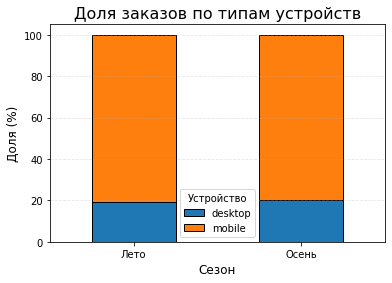

In [49]:
device_season = (
    merged_data.groupby(['season', 'device_type_canonical'])['order_id']
    .count()
    .unstack()
    .apply(lambda x: x/x.sum()*100, axis=1)
)

plt.figure(figsize=(8, 5))
device_season.plot(
    kind='bar', 
    stacked=True, 
    color=['#1f77b4', '#ff7f0e'],
    edgecolor='black'
)
plt.title('Доля заказов по типам устройств', fontsize=16)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Доля (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Устройство')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Значимых различий в используемых девайсах в разрезе сезона не наблюдается. Различия в сезонах не превышают 1%.

#### 5.1.4. Анализ метрик в разрезе времени

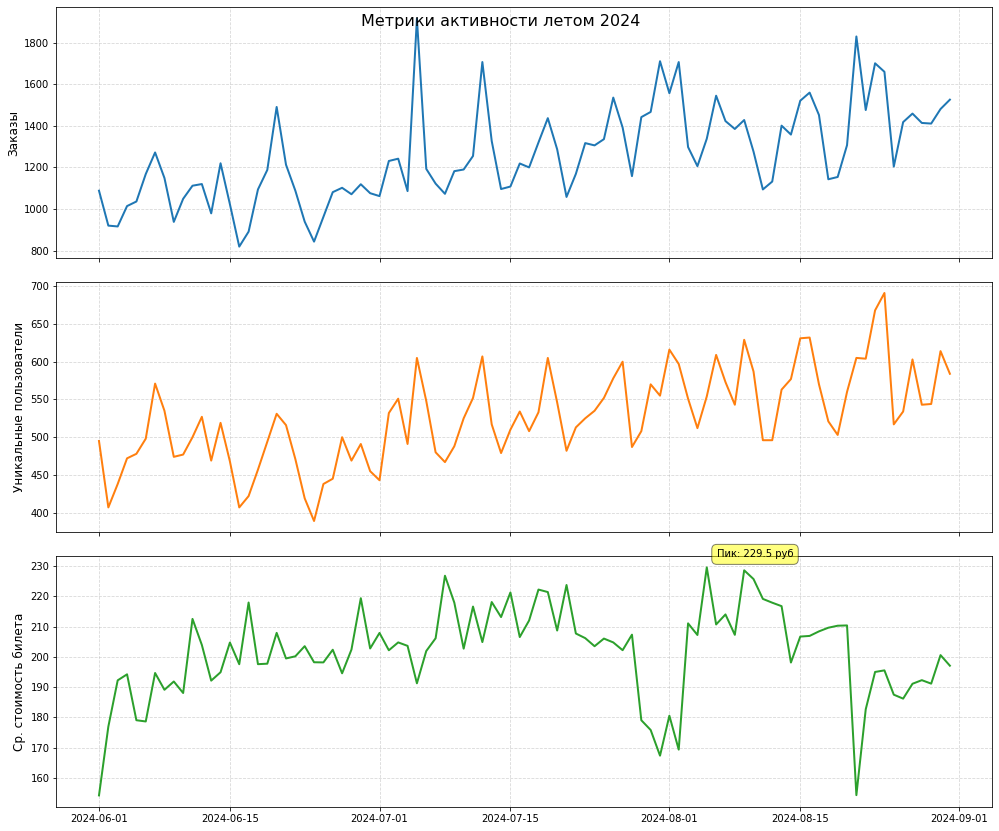

In [50]:

summer_data = merged_data[merged_data['season'] == 'Лето'].copy()

if not summer_data.empty:
    daily_summer = summer_data.groupby('created_dt_msk').agg({
        'order_id': 'count',
        'user_id': 'nunique',
        'one_ticket_revenue_rub': 'mean',
        'event_type_main': lambda x: x.mode()[0] if not x.empty else None
    }).rename(columns={
        'order_id': 'Заказы',
        'user_id': 'Уникальные пользователи',
        'one_ticket_revenue_rub': 'Ср. стоимость билета'
    })


    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    metrics = ['Заказы', 'Уникальные пользователи', 'Ср. стоимость билета']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, metric in enumerate(metrics):
        if not daily_summer[metric].empty:
            axes[i].plot(daily_summer.index, daily_summer[metric], color=colors[i], linewidth=2)
            axes[i].set_ylabel(metric, fontsize=12)
            axes[i].grid(True, linestyle='--', alpha=0.5)
            

            if metric == 'Ср. стоимость билета' and not daily_summer[metric].isnull().all():
                max_val = daily_summer[metric].max()
                max_date = daily_summer[metric].idxmax()
                axes[i].annotate(f'Пик: {max_val:.1f} руб', 
                               xy=(max_date, max_val),
                               xytext=(10, 10), 
                               textcoords='offset points',
                               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.suptitle('Метрики активности летом 2024', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных за летний период")

По графикам особо никаких аномалий не наблюдается. В целом, тренды заказов и прироста новых пользователей совпадают: постепенный рост начался с июля на обоих графиках. А вот стоимость билета постепенно росла с июня по конец июля, а потом наблюдается резкое сокращение стоимость билетов (в конце июля- начале августа), далее наблюдается вновь скачок стоимости билета и постепенный ее спад.

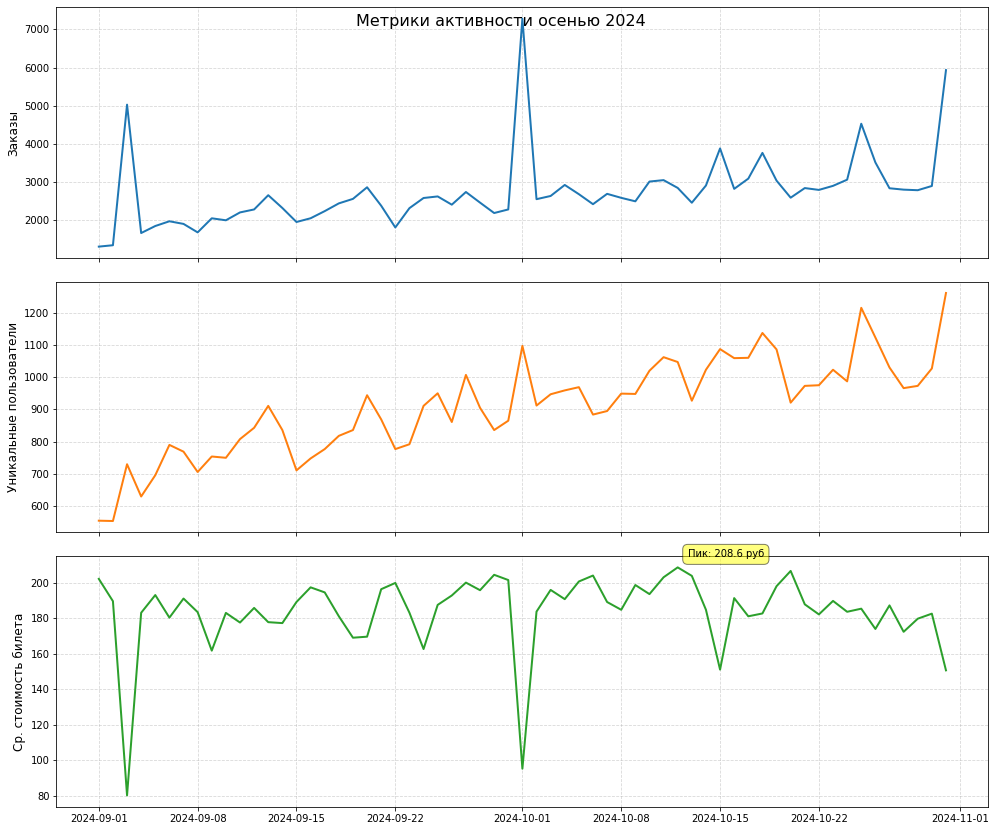

In [51]:
# 1. Активность пользователей летом с защитой от пустых данных
autumn_data = merged_data[merged_data['season'] == 'Осень'].copy()

if not autumn_data.empty:
    # Рассчитываем дневные метрики
    daily_autumn = autumn_data.groupby('created_dt_msk').agg({
        'order_id': 'count',
        'user_id': 'nunique',
        'one_ticket_revenue_rub': 'mean',
        'event_type_main': lambda x: x.mode()[0] if not x.empty else None
    }).rename(columns={
        'order_id': 'Заказы',
        'user_id': 'Уникальные пользователи',
        'one_ticket_revenue_rub': 'Ср. стоимость билета'
    })

    # Визуализация
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    metrics = ['Заказы', 'Уникальные пользователи', 'Ср. стоимость билета']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, metric in enumerate(metrics):
        if not daily_autumn[metric].empty:
            axes[i].plot(daily_autumn.index, daily_autumn[metric], color=colors[i], linewidth=2)
            axes[i].set_ylabel(metric, fontsize=12)
            axes[i].grid(True, linestyle='--', alpha=0.5)
            
            # Аннотируем экстремальные значения с проверкой
            if metric == 'Ср. стоимость билета' and not daily_autumn[metric].isnull().all():
                max_val = daily_autumn[metric].max()
                max_date = daily_autumn[metric].idxmax()
                axes[i].annotate(f'Пик: {max_val:.1f} руб', 
                               xy=(max_date, max_val),
                               xytext=(10, 10), 
                               textcoords='offset points',
                               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.suptitle('Метрики активности осенью 2024', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных за осенний период")

За осень данные, конечно интереснее выглядят.
Количество посетителей и закаазов явно плавно растет, а вот цена билета средняя с октября постепенно идет на спад.
Также в данных наблюдается несколько значительных аномалий, связанных с резкими падениями на стоимость билета и увеличением спроса на билеты. Возможно, в эти даты проводились какие-то маркетинговые акции, связанные с промокодами и скидками на билеты.

<Figure size 1008x720 with 0 Axes>

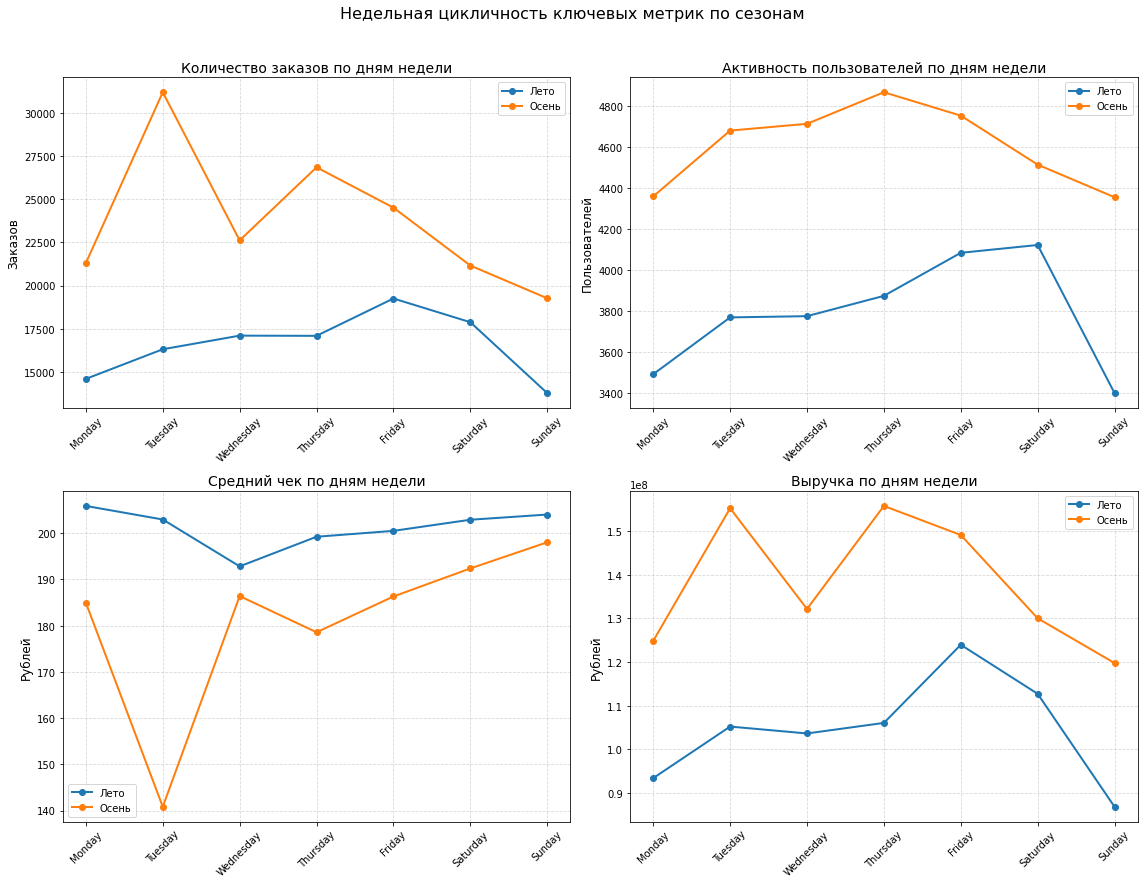

In [52]:
# Анализ недельной цикличности
plt.figure(figsize=(14, 10))

weekday_data = merged_data.copy()
weekday_data['day_of_week'] = pd.to_datetime(weekday_data['created_dt_msk']).dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_data['day_of_week'] = pd.Categorical(weekday_data['day_of_week'], 
                                            categories=weekday_order,
                                            ordered=True)


weekday_metrics = weekday_data.groupby(['season', 'day_of_week']).agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'one_ticket_revenue_rub': 'mean',
    'total_rub': 'sum'
}).rename(columns={
    'order_id': 'Количество заказов',
    'user_id': 'Уникальные пользователи',
    'one_ticket_revenue_rub': 'Средний чек',
    'total_rub': 'Общая выручка'
})


for metric in ['Количество заказов', 'Уникальные пользователи', 'Общая выручка']:
    weekday_metrics[f'{metric} (норм.)'] = (
        weekday_metrics[metric] / weekday_metrics.groupby('season')[metric].transform('max')
    )

metrics_to_plot = {
    'Количество заказов': ('Количество заказов по дням недели', 'Заказов'),
    'Уникальные пользователи': ('Активность пользователей по дням недели', 'Пользователей'),
    'Средний чек': ('Средний чек по дням недели', 'Рублей'),
    'Общая выручка': ('Выручка по дням недели', 'Рублей')
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (metric, (title, ylabel)) in enumerate(metrics_to_plot.items()):
    for season in ['Лето', 'Осень']:
        data = weekday_metrics.xs(season, level=0)[metric]
        axes[idx].plot(data.index, data, label=season, marker='o', linewidth=2)
    
    axes[idx].set_title(title, fontsize=14)
    axes[idx].set_ylabel(ylabel, fontsize=12)
    axes[idx].grid(True, linestyle='--', alpha=0.5)
    axes[idx].legend(fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Недельная цикличность ключевых метрик по сезонам', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



В целом, графики по сезонам в разрезе дней недели достаточно похожи. Но различия все-таки имеются:

- количество заказов осенью больше в первой половине недели, в отличия от лета. 
- а вот средний чек в первую половину ниже, видимо есть кака-то промо акция, которая дает скидки по будням

### Анализ активности регионов

In [53]:
# Подготовка данных для определения топ-5 регионов по выручке
region_revenue = autumn_data.groupby('region_name')['revenue_rub'].sum().nlargest(5)

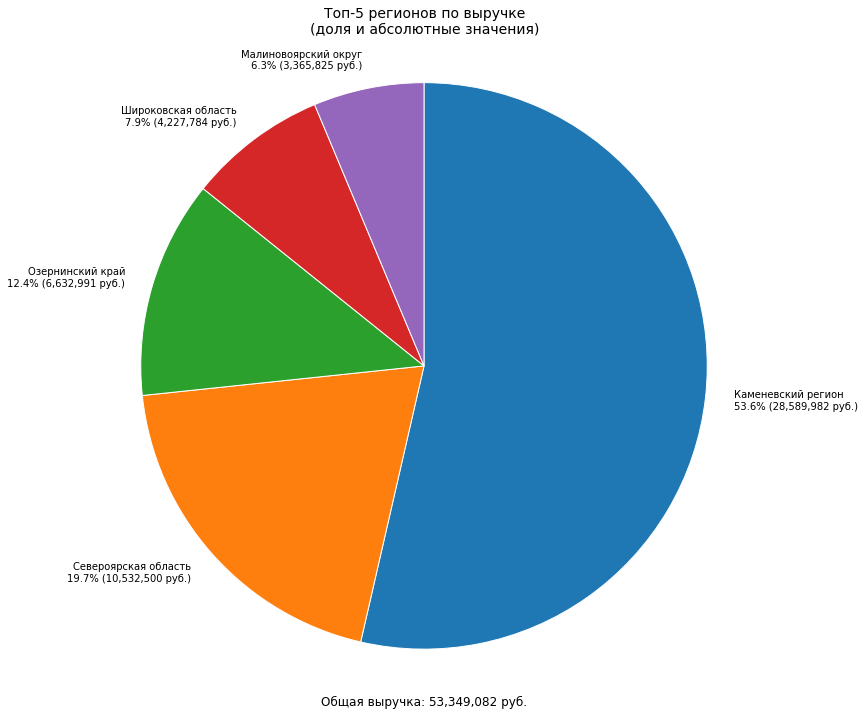

In [54]:
plt.figure(figsize=(11, 10))
total = region_revenue.sum()
percentages = (region_revenue / total * 100).round(1)
labels = [f'{region}\n{percent}% ({revenue:,.0f} руб.)' 
          for region, percent, revenue in zip(region_revenue.index, 
                                           percentages, 
                                           region_revenue)]

patches, texts, autotexts = plt.pie(
    region_revenue,
    labels=labels,
    autopct='', 
    startangle=90,
    counterclock=False,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)


plt.title('Топ-5 регионов по выручке\n(доля и абсолютные значения)', fontsize=14, pad=20)
plt.axis('equal') 
plt.text(0, -1.2, f'Общая выручка: {total:,.0f} руб.', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

 Наиболее прибыльный регион - Каменевский (28 589 982 р.), он создает 53.6 % от 5 топовых регионов.
На втором месте - Североярская область (10 532 500 р.) - 19.7%
На третьем - Озернинский край ( 6 632 991 р.) - 12.4%
На четвертом - Широковская область (4 227 784 р.) - 7.9%
На пятом - Малиновский округ (3 365 825 р.) - 6.3%.

Значительную часть от всей выручки приносят два региона - Каменевский и Североярская область.

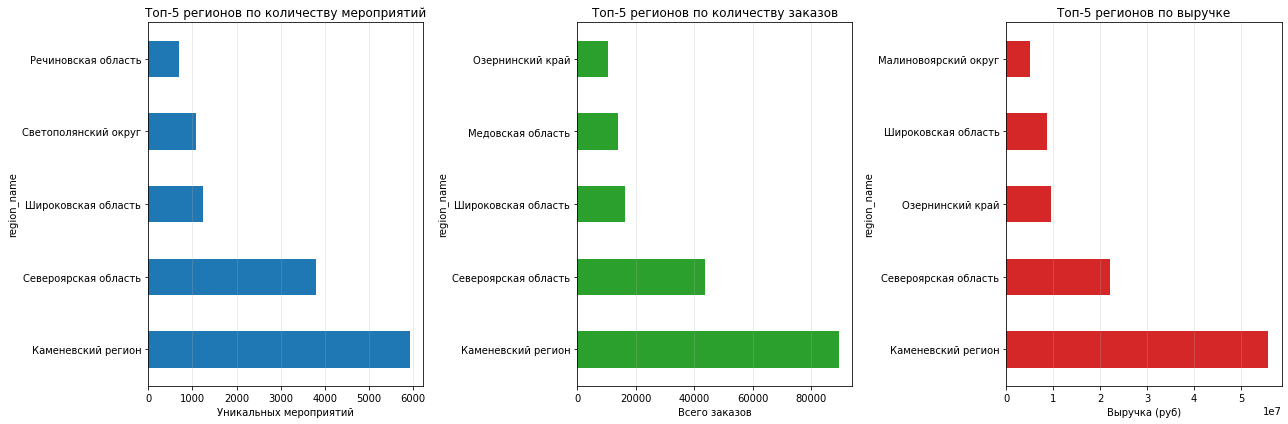

,event_id,order_id,revenue_rub,Доля мероприятий,Доля заказов,Доля выручки
region_name,,,,,,
Каменевский регион,"5,935","89,593","55,886,449 руб.",26.6%,31.7%,38.7%
Североярская область,"3,800","43,737","22,102,085 руб.",17.1%,15.5%,15.3%
Озернинский край,349,"10,348","9,407,522 руб.",1.6%,3.7%,6.5%
Широковская область,"1,232","16,169","8,628,101 руб.",5.5%,5.7%,6.0%
Малиновоярский округ,165,"6,314","5,089,834 руб.",0.7%,2.2%,3.5%
Яблоневская область,535,"6,123","3,505,459 руб.",2.4%,2.2%,2.4%
Светополянский округ,"1,075","7,501","3,037,787 руб.",4.8%,2.7%,2.1%
Медовская область,504,"13,892","2,927,650 руб.",2.3%,4.9%,2.0%
Речиновская область,702,"6,266","2,630,250 руб.",3.2%,2.2%,1.8%


In [55]:
# Анализ региональной активности
region_analysis = merged_data.groupby('region_name').agg({
    'event_id': 'nunique',
    'order_id': 'count',
    'revenue_rub': 'sum'
}).sort_values('revenue_rub', ascending=False)

region_analysis['Доля мероприятий'] = (region_analysis['event_id'] / region_analysis['event_id'].sum() * 100).round(1)
region_analysis['Доля заказов'] = (region_analysis['order_id'] / region_analysis['order_id'].sum() * 100).round(1)
region_analysis['Доля выручки'] = (region_analysis['revenue_rub'] / region_analysis['revenue_rub'].sum() * 100).round(1)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Количество мероприятий
region_analysis['event_id'].nlargest(5).plot(kind='barh', ax=axes[0], color='#1f77b4')
axes[0].set_title('Топ-5 регионов по количеству мероприятий')
axes[0].set_xlabel('Уникальных мероприятий')

# Количество заказов
region_analysis['order_id'].nlargest(5).plot(kind='barh', ax=axes[1], color='#2ca02c')
axes[1].set_title('Топ-5 регионов по количеству заказов')
axes[1].set_xlabel('Всего заказов')

# Выручка
region_analysis['revenue_rub'].nlargest(5).plot(kind='barh', ax=axes[2], color='#d62728')
axes[2].set_title('Топ-5 регионов по выручке')
axes[2].set_xlabel('Выручка (руб)')

for ax in axes:
    ax.grid(axis='x', alpha=0.3)
    
plt.tight_layout()
plt.show()

# Вывод таблицы 
display(region_analysis.head(10).style.format({
    'event_id': '{:,}',
    'order_id': '{:,}',
    'revenue_rub': '{:,.0f} руб.',
    'Доля мероприятий': '{:.1f}%',
    'Доля заказов': '{:.1f}%',
    'Доля выручки': '{:.1f}%'
}))

**На основе предоставленных данных можно сделать следующие ключевые выводы:**

Абсолютный лидер - Каменевский регион (генерирует выручки больше, чем следующие 4 региона вместе взятые):
- 26.6% всех мероприятий (5 935)
- 31.7% всех заказов (89 607)
- 38.7% всей выручки (55.9 млн руб.)
- Высокая эффективность: 9 418 руб. выручки на мероприятие (среднее)

Второй эшелон:

- Североярская область: 17.1% мероприятий, 15.3% выручки
- Озернинский край: всего 1.6% мероприятий, но 6.5% выручки (высокая эффективность)
- Широковская область: стабильные 5-6% по всем показателям

Проблемные регионы:

- Малиновоярский округ: 0.7% мероприятий, 3.5% выручки (аномально высокая выручка, но мало мероприятий)
- Медовская область: 2.3% мероприятий,только 2% выручки (низкая эффективность)



### Анализ активности партнеров

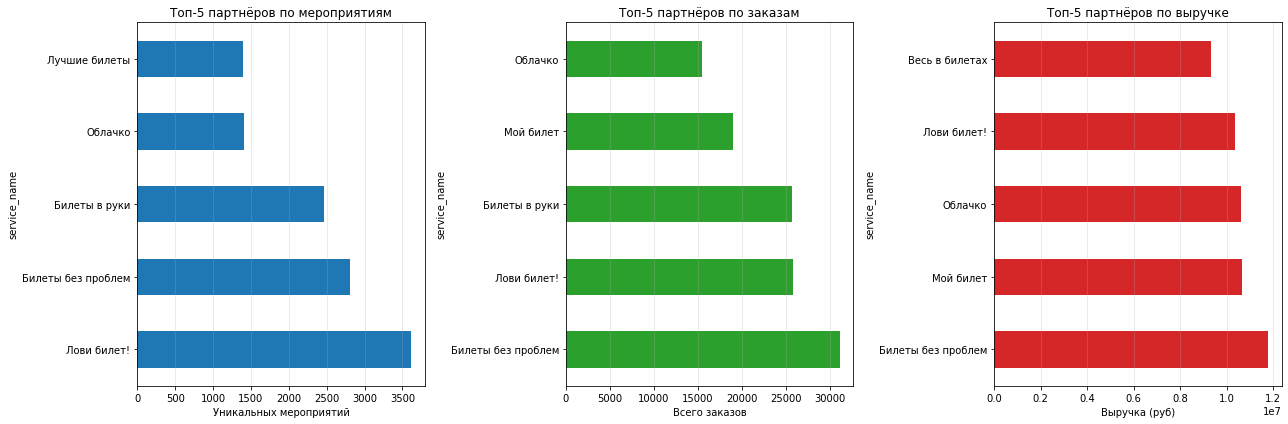

,event_id,order_id,revenue_rub,Средняя выручка на мероприятие,Средний чек,Доля мероприятий,Доля заказов,Доля выручки
service_name,,,,,,,,
Билеты без проблем,"2,808","31,105","11,772,525 руб.","4,192 руб.",378 руб.,16.3%,18.6%,14.5%
Мой билет,992,"19,033","10,666,858 руб.","10,753 руб.",560 руб.,5.8%,11.4%,13.1%
Облачко,"1,409","15,478","10,611,052 руб.","7,531 руб.",686 руб.,8.2%,9.3%,13.1%
Лови билет!,"3,616","25,792","10,376,793 руб.","2,870 руб.",402 руб.,21.0%,15.5%,12.8%
Весь в билетах,599,"9,405","9,324,686 руб.","15,567 руб.",991 руб.,3.5%,5.6%,11.5%
Билеты в руки,"2,471","25,732","7,613,325 руб.","3,081 руб.",296 руб.,14.3%,15.4%,9.4%
Край билетов,193,"2,997","3,018,373 руб.","15,639 руб.","1,007 руб.",1.1%,1.8%,3.7%
Яблоко,537,"3,473","2,763,332 руб.","5,146 руб.",796 руб.,3.1%,2.1%,3.4%
Прачечная,728,"5,798","2,548,310 руб.","3,500 руб.",440 руб.,4.2%,3.5%,3.1%


In [56]:
# Анализ активности партнёров
partner_analysis = autumn_data.groupby('service_name').agg({
    'event_id': 'nunique',
    'order_id': 'count',
    'revenue_rub': 'sum'
}).sort_values('revenue_rub', ascending=False)


partner_analysis['Средняя выручка на мероприятие'] = (partner_analysis['revenue_rub'] / partner_analysis['event_id']).round()
partner_analysis['Средний чек'] = (partner_analysis['revenue_rub'] / partner_analysis['order_id']).round()
partner_analysis['Доля мероприятий'] = (partner_analysis['event_id'] / partner_analysis['event_id'].sum() * 100).round(1)
partner_analysis['Доля заказов'] = (partner_analysis['order_id'] / partner_analysis['order_id'].sum() * 100).round(1)
partner_analysis['Доля выручки'] = (partner_analysis['revenue_rub'] / partner_analysis['revenue_rub'].sum() * 100).round(1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Количество мероприятий
partner_analysis['event_id'].nlargest(5).plot(kind='barh', ax=axes[0], color='#1f77b4')
axes[0].set_title('Топ-5 партнёров по мероприятиям')
axes[0].set_xlabel('Уникальных мероприятий')

# Количество заказов
partner_analysis['order_id'].nlargest(5).plot(kind='barh', ax=axes[1], color='#2ca02c')
axes[1].set_title('Топ-5 партнёров по заказам')
axes[1].set_xlabel('Всего заказов')

# Выручка
partner_analysis['revenue_rub'].nlargest(5).plot(kind='barh', ax=axes[2], color='#d62728')
axes[2].set_title('Топ-5 партнёров по выручке')
axes[2].set_xlabel('Выручка (руб)')

for ax in axes:
    ax.grid(axis='x', alpha=0.3)
    
plt.tight_layout()
plt.show()

# Вывод таблицы с аналитикой по партнёрам
display(partner_analysis.head(10).style.format({
    'event_id': '{:,}',
    'order_id': '{:,}',
    'revenue_rub': '{:,.0f} руб.',
    'Средняя выручка на мероприятие': '{:,.0f} руб.',
    'Средний чек': '{:,.0f} руб.',
    'Доля мероприятий': '{:.1f}%',
    'Доля заказов': '{:.1f}%',
    'Доля выручки': '{:.1f}%'
}))

**На основе предоставленных данных о партнерах можно выделить несколько ключевых групп:**

Лидеры по объему продаж:
- "Билеты без проблем" - абсолютный лидер по количеству заказов (31 110, доля от всей выручки - 14.5%, но низкий средний чек -378р.)
- "Мой билет" - высокая средняя выручка на мероприятие (10 754 руб., доля от всей выручки 13.1%)
- "Облачко" - баланс объема и качества (15 478 заказов, 686 руб. средний чек, доля от всей выручки 13.1%)

Премиальные партнеры:
- "Край билетов" - рекордный средний чек (1 007 руб.), максимальная выручка на мероприятие (15 639 руб.). дает примерно такую же выручку как "Весь в билетах", но значительно меньшее количество заказов
- "Весь в билетах" - высокий средний чек и выручка с одного мероприятия (991 руб, 15 567руб.) и видимо из-за этогоне шибко большое количество заказов (5.6% от всех).

Массовые партнеры:
- "Лови билет!" - максимальное количество мероприятий (3 616 или 21% от всех мероприятий), но только 2 870 р. выручки на мероприятие.
- "Билеты в руки" - низкий средний чек (296 руб.) и большое количество заказов (25 732)



**Итоговые выводы по главе:**

Осенний рост спроса (+35-40% по сравнению с летом).
Снижение среднего чека на 10-18%.
Концерты - абсолютный лидер (113 467 билетов - 39% от всех заказов), что в 1.7x больше театров.Категория "Другое" требует пересмотра - необходимо детализировать состав

Наблюдается парадокс: рост спроса осенью сопровождается снижением средней цены билета на 10-18% для ключевых категорий. Исключение: стендап (+5.8%) и выставки (+4.9%) показали рост цен при увеличении спроса. Концерты упали в цене на 10.9% при максимальном объеме продаж. Неплохо бы исследовать причины  
Осенний рост семейных мероприятий  и категории 12+. Снижение спроса на "взрослые" мероприятия (18+, 21+)

Площадки: Успешный запуск новых площадок ("Платформа" и "Светлячок"). Проблемы у части площадок ("Вдох" - полное прекращение продаж)


Мобильные пользователи в стравнении с десктопными имеют в 2.8x больше заказов, на 28% выше конверсия (11.7 vs 8.1 заказов/пользователя), но средний чек на 4.5% ниже. Десктоп-аудитория, вероятно совершает меньше импульсивных покупок.


Каменевский регион демонстрирует экстремальную концентрацию ресурсов:
В 3.5 раза больше мероприятий, чем в Североярской области (5,940 vs 1,700). Выручка в 19 раз выше, чем у аутсайдеров (56.1 млн vs 2.9 млн)

Партнеры лидеры по объему продаж:
- "Билеты без проблем" - абсолютный лидер по количеству заказов (31 110, доля от всей выручки - 14.5%, но низкий средний чек -378р.)
- "Мой билет" - высокая средняя выручка на мероприятие (10 754 руб., доля от всей выручки 13.1%)
- "Облачко" - баланс объема и качества (15 478 заказов, 686 руб. средний чек, доля от всей выручки 13.1%)
- "Край билетов" - максимальный средний чек (1,007 руб.).
Рекомендации:
- Усилить продвижение в Каменевском регионе и Североярской области т.к. они приносят наибольшую выручку.
- Разработать программы лояльности для мобильных пользователей
- Возможно сделать сезонные акции для семейной аудитории (сентябрь-октябрь), хотя возможно именно из-за них произошло падение выручки
- Исследовать причины падения цен на концерты и театры
- Рассмотреть динамическое ценообразование для популярных мероприятий
- Детализировать категорию "Другое", т.к. не совсем понятно из чего она состоит. Ограниченна ли она возрастными рамками?
- Увеличить долю стендап-мероприятий, потому что наблюдается рост цен и стабильный спрос
- Изучить с чем связан успех Студии дизайна "Платформа" Инкорпорейтед  для использования и переноса опыта на другие площадки.
- Некоторые партнеры чрезмерно завышают (Весь в билетах Край билетов) или занижают (Билеты в руки) стоимость билетов, из-за чего идет диспропорция спроса стоит пересмотреть их ценовую политику 
- исследовать, связано ли падение выручки осенью с изменением состава мероприятий. Возможно, стоит проверить гипотезу о сезонных скидках.
- можно сравнить текущие данные с предыдущими периодами, чтобы понять является ли данная динамика закономерной.



<a class='anchor' id="ch4"></a>
## 4. Статистический анализ данных

In [57]:
#удаляем пропуски в столбце, чтобы не искжать среднее и медиану. Пропуски означалют, что покупки не было.
autumn_data=autumn_data.dropna(subset=['days_since_prev'])

In [58]:

user_stats = autumn_data.groupby(['user_id', 'device_type_canonical']).agg(
    order_count=('order_id', 'count'),
    days_between=('days_since_prev', lambda x: x[x > 0].mean())
).reset_index()

In [59]:
user_stats

,user_id,device_type_canonical,order_count,days_between
0,0005ca5e93f2cf4,mobile,1,75.000000
1,000898990054619,mobile,2,51.000000
2,000a55a418c128c,mobile,1,16.000000
3,001e7037d013f0f,mobile,2,43.500000
4,00245c702bc343e,mobile,2,27.500000
...,...,...,...,...
13960,ffed3ff067d4f12,mobile,3,39.000000
13961,fff13b79bd47d7c,mobile,3,20.666667
13962,fff32fc9ad0f9f6,desktop,1,74.000000
13963,fffcd3dde79eb2c,desktop,2,2.500000


In [60]:
mobile_users = user_stats[user_stats['device_type_canonical'] == 'mobile']
desktop_users = user_stats[user_stats['device_type_canonical'] == 'desktop']

# 2. Описательная статистика
print("Описательная статистика количества заказов:")
print(pd.concat([
    mobile_users['order_count'].describe().rename('Мобильные'),
    desktop_users['order_count'].describe().rename('Десктоп')
], axis=1))

print("\nОписательная статистика интервалов между заказами:")
print(pd.concat([
    mobile_users['days_between'].describe().rename('Мобильные'),
    desktop_users['days_between'].describe().rename('Десктоп')
], axis=1))

Описательная статистика количества заказов:
         Мобильные      Десктоп
count  9997.000000  3968.000000
mean     12.618386     8.235131
std      80.578144    39.636690
min       1.000000     1.000000
25%       1.000000     1.000000
50%       3.000000     2.000000
75%       6.000000     4.000000
max    4329.000000  1498.000000

Описательная статистика интервалов между заказами:
         Мобильные      Десктоп
count  8654.000000  3481.000000
mean     30.057251    21.222250
std      30.187555    27.603844
min       1.000000     1.000000
25%       8.000000     3.200000
50%      19.200000     9.000000
75%      42.000000    28.000000
max     148.000000   146.000000


In [61]:
print(f"Всего пользователей: {len(user_stats)}")
print(f"Мобильные пользователи: {len(mobile_users)}")
print(f"Десктопные пользователи: {len(desktop_users)}")


Всего пользователей: 13965
Мобильные пользователи: 9997
Десктопные пользователи: 3968


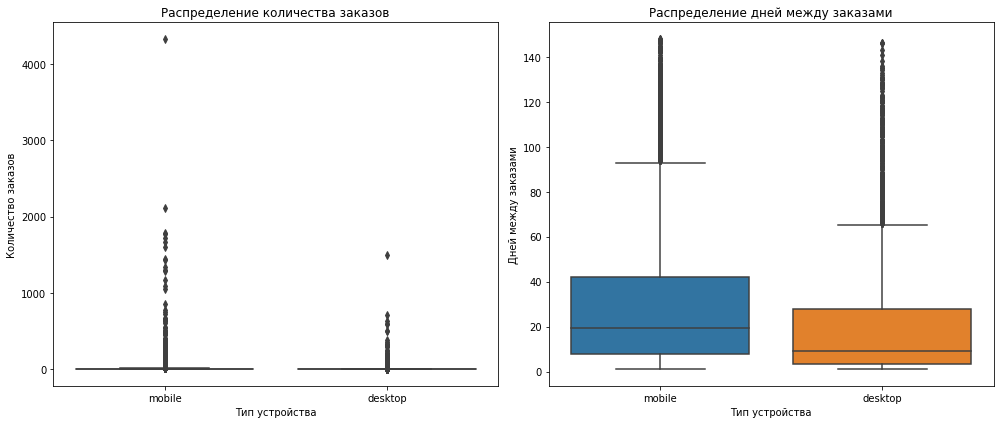

In [62]:
# Визуализация распределений
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=user_stats, x='device_type_canonical', y='order_count')
plt.title('Распределение количества заказов')
plt.xlabel('Тип устройства')
plt.ylabel('Количество заказов')

plt.subplot(1, 2, 2)
sns.boxplot(data=user_stats, x='device_type_canonical', y='days_between')
plt.title('Распределение дней между заказами')
plt.xlabel('Тип устройства')
plt.ylabel('Дней между заказами')

plt.tight_layout()
plt.show()


распределения визульно друг от друга не отличаются, большая дисперсия у мобильных пользователей, очевидно, связана с большим размером выборки

Статичтические тесты устойчивы к разным размерам выборок и не требуют одинаково размера.
Но есть нюансы:

- Для t-теста: если дисперсии равны, то разница в размерах выборок не критична. Если дисперсии не равны, то используется поправка Уэлча, которая учитывает разницу в размерах и дисперсиях.
-  Для U-теста Манна-Уитни: метод не требует одинаковых размеров выборок и устойчив к разным размерам.

### 4.1. Гипотеза 1: Среднее количество заказов на пользователя

Нулеваы гипотеза: Покупатели с мобильных менее актины или равны по активности покупателям с компьютеров
H₀: μ_mobile ≤ μ_desktop 
Альтернативная гипотеза: Мобильные пользователи активнее
H₁: μ_mobile > μ_desktop 




 ГИПОТЕЗА 1: Количество заказов

 Проверка нормальности: Мобильные - Количество заказов 


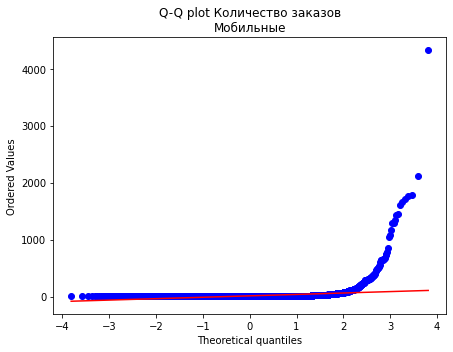

Тест Колмогорова-Смирнова: statistic=0.4427, p-value=0.00000
Распределение НЕ нормальное (p < 0.05)

 Проверка нормальности: Десктопные - Количество заказов 


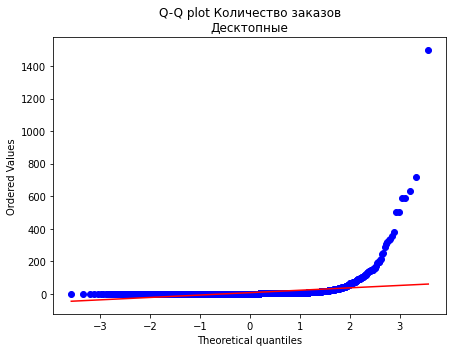

Тест Шапиро-Уилка: statistic=0.1402, p-value=0.00000
Распределение НЕ нормальное (p < 0.05)


In [63]:
# Проверка нормальности распределения
def check_normality(data, group_name, variable):
    print(f"\n Проверка нормальности: {group_name} - {variable} ")
    plt.figure(figsize=(12, 5))   
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot {variable}\n{group_name}')
    
    plt.tight_layout()
    plt.show()
     # Тест Шапиро-Уилка (для выборок <5000)
    if len(data) < 5000:
        stat, p = stats.shapiro(data)
        print(f"Тест Шапиро-Уилка: statistic={stat:.4f}, p-value={p:.5f}")
        if p > 0.05:
            print("Распределение нормальное (p > 0.05)")
        else:
            print("Распределение НЕ нормальное (p < 0.05)")
    
    # Тест Колмогорова-Смирнова для больших выборок
    else:
        stat, p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        print(f"Тест Колмогорова-Смирнова: statistic={stat:.4f}, p-value={p:.5f}")
        if p > 0.05:
            print("Распределение нормальное (p > 0.05)")
        else:
            print("Распределение НЕ нормальное (p < 0.05)")
    
    return p < 0.05  # Возвращает True если распределение НЕ нормальное


# Проверка для количества заказов
print("\n ГИПОТЕЗА 1: Количество заказов")
non_normal_mobile = check_normality(mobile_users['order_count'], "Мобильные", "Количество заказов")
non_normal_desktop = check_normality(desktop_users['order_count'], "Десктопные", "Количество заказов")
non_normal_orders = non_normal_mobile or non_normal_desktop

В обеих выборках наблюдаются выбросы в данных, соответственно необходимо использовать тест Манна-Уитни.

In [64]:
# Проверка гипотез с учетом нормальности
print("\n РЕЗУЛЬТАТЫ ТЕСТОВ ")

# Гипотеза 1: Среднее количество заказов (mobile > desktop)

# Непараметрический тест Манна-Уитни
u_stat, p_value = stats.mannwhitneyu(mobile_users['order_count'],
                                     desktop_users['order_count'],
                                     alternative='greater')
test_name = "U-тест Манна-Уитни"
test_stat = f"U={u_stat:.0f}"

print(f"\nГипотеза 1: Среднее количество заказов (mobile > desktop)")
print(f"Тест: {test_name}, {test_stat}, p-value={p_value:.5f}")
print(f"Среднее количество заказов по мобильному: {mobile_users['order_count'].mean():.1f}")
print(f"Среднее колиество заказов через компьютер: {desktop_users['order_count'].mean():.1f}")



 РЕЗУЛЬТАТЫ ТЕСТОВ 

Гипотеза 1: Среднее количество заказов (mobile > desktop)
Тест: U-тест Манна-Уитни, U=22034480, p-value=0.00000
Среднее количество заказов по мобильному: 12.6
Среднее колиество заказов через компьютер: 8.2


In [65]:
# Дополнительная проверка медиан (более устойчивый показатель)
median_mobile = mobile_users['order_count'].median()
median_desktop = desktop_users['order_count'].median()
print(f"Медиана заказов (мобильные): {median_mobile}")
print(f"Медиана заказов (десктоп): {median_desktop}")

Медиана заказов (мобильные): 3.0
Медиана заказов (десктоп): 2.0


Значение Cohen's показывает на сколько стандартных отклонений средние значения двух групп отличаются друг от друга. Практическое значение его в том, что даже если p-value < 0.05, но d < 0.2 — разница есть, но она не имеет практического значения.

In [66]:
#Проверка размера эффекта, если <0.2 - эффект незначительный
cohen_d = (mean(mobile_users['order_count']) - mean(desktop_users['order_count'])) / sqrt((std(mobile_users['order_count'])**2 + std(desktop_users['order_count'])**2)/2)
print(f"Cohen's d: {cohen_d:.3f}")

Cohen's d: 0.069


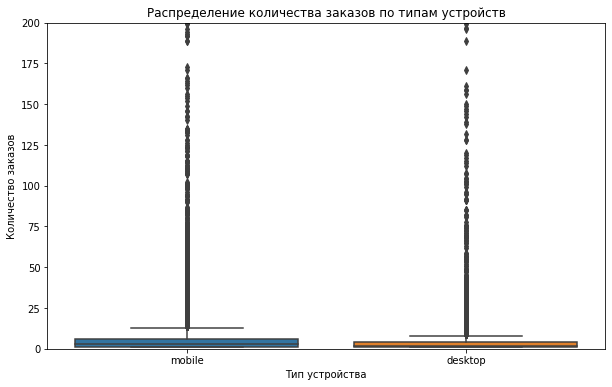

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_stats, x='device_type_canonical', y='order_count')
plt.title('Распределение количества заказов по типам устройств')
plt.xlabel('Тип устройства')
plt.ylabel('Количество заказов')
plt.ylim(0, 200)
plt.show()

Вывод: 
 Мобильные пользователи в среднем делают чуть больше заказов, но для большинства пользователей разницы нет.

Гипотеза подтверждена p-value=0.00000<0.05, но разница не имеет практического значения (d = 0.045).Средние значения отличаются, но медианы одинаковы (2.0).

Разница в средних вызвана небольшим числом активных пользователей с аномально высоким числом заказов.



### 4.2. Гипотеза 2: Время между заказами (mobile < desktop)

Нулеваы гипотеза: Время между заказами у мобильных пользователей не превышает времени между заказами через десктопные устройства

H₀: mobile <= desktop 

Альтернативная гипотеза: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств

H₁: mobile > desktop 


In [68]:
# Разделяем на группы
mobile_users = user_stats[user_stats['device_type_canonical'] == 'mobile']['days_between'].dropna()
desktop_users = user_stats[user_stats['device_type_canonical'] == 'desktop']['days_between'].dropna()

print("Описательная статистика времени между заказами (дни):")
print(pd.DataFrame({
    'Мобильные': mobile_users.describe(),
    'Десктоп': desktop_users.describe()
}).round(1))


Описательная статистика времени между заказами (дни):
       Мобильные  Десктоп
count     8654.0   3481.0
mean        30.1     21.2
std         30.2     27.6
min          1.0      1.0
25%          8.0      3.2
50%         19.2      9.0
75%         42.0     28.0
max        148.0    146.0



Проверка нормальности для мобильные пользователи:


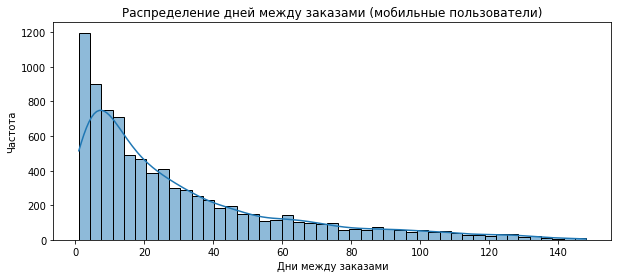

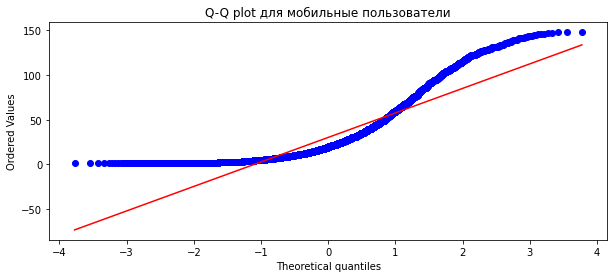

Тест Колмогорова-Смирнова: statistic=0.1679, p-value=0.00000
Распределение НЕ нормальное (p < 0.05)

Проверка нормальности для десктоп пользователи:


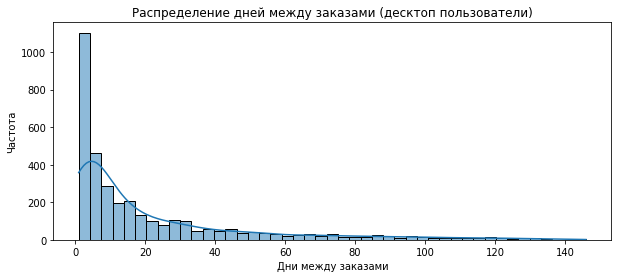

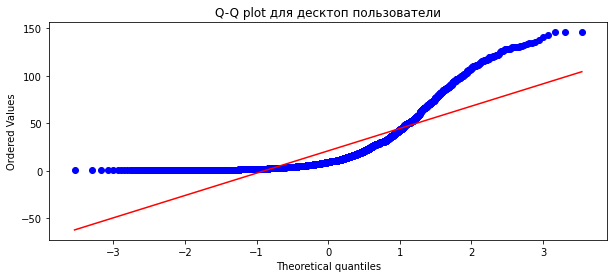

Тест Шапиро-Уилка: statistic=0.7240, p-value=0.00000
Распределение НЕ нормальное (p < 0.05)


In [69]:
def check_normality(data, group_name):
    print(f"\nПроверка нормальности для {group_name}:")

    plt.figure(figsize=(10, 4))
    sns.histplot(data, kde=True)
    plt.title(f'Распределение дней между заказами ({group_name})')
    plt.xlabel('Дни между заказами')
    plt.ylabel('Частота')
    plt.show()
    
    plt.figure(figsize=(10, 4))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot для {group_name}')
    plt.show()
    
    # Тест Шапиро-Уилка (для выборок <5000)
    if len(data) < 5000:
        stat, p = stats.shapiro(data)
        print(f"Тест Шапиро-Уилка: statistic={stat:.4f}, p-value={p:.5f}")
        if p > 0.05:
            print("Распределение нормальное (p > 0.05)")
        else:
            print("Распределение НЕ нормальное (p < 0.05)")
    else:
        # Тест Колмогорова-Смирнова для больших выборок
        stat, p = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
        print(f"Тест Колмогорова-Смирнова: statistic={stat:.4f}, p-value={p:.5f}")
        if p > 0.05:
            print("Распределение нормальное (p > 0.05)")
        else:
            print("Распределение НЕ нормальное (p < 0.05)")
    
    return p < 0.05  

# Проверяем нормальность для обеих групп
not_normal_mobile = check_normality(mobile_users, "мобильные пользователи")
not_normal_desktop = check_normality(desktop_users, "десктоп пользователи")


Оба распределения значительно отличаются от нормального, это подтверждают как графики, так и p-value=0.00000.
С обоих устройств время между заказами редко превышает 60 дней, зачастую повторный заказ делают в пределах 20 дней. 

In [70]:
# Проверка равенства дисперсий
_, p_var = stats.levene(mobile_users, desktop_users)
equal_var = p_var > 0.05
print(f"\nТест Левена на равенство дисперсий: p-value={p_var:.4f}",
      "(дисперсии равны)" if equal_var else "(дисперсии не равны)")


Тест Левена на равенство дисперсий: p-value=0.0000 (дисперсии не равны)


In [71]:
print("\nИспользуем U-тест Манна-Уитни (дисперсии не равны)")
t_stat, p_value = stats.mannwhitneyu(mobile_users, desktop_users, alternative="greater")  

print(f"\nСтатистика U-теста: {t_stat:.4f}\np-value: {p_value:.5f}")

print(f"Среднее количество дней между заказами через мобильный: {mobile_users.mean():.1f}")
print(f"Среднее колиество дней между заказами через компьютер: {desktop_users.mean():.1f}")




Используем U-тест Манна-Уитни (дисперсии не равны)

Статистика U-теста: 18917881.0000
p-value: 0.00000
Среднее количество дней между заказами через мобильный: 30.1
Среднее колиество дней между заказами через компьютер: 21.2


In [72]:
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    s_pooled = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1))/dof)
    d = abs((x.mean()-y.mean()))/s_pooled
    return d

effect_size = cohen_d(mobile_users, desktop_users)
print(f"\nРазмер эффекта (Cohen's d): {effect_size:.3f}")



Размер эффекта (Cohen's d): 0.300


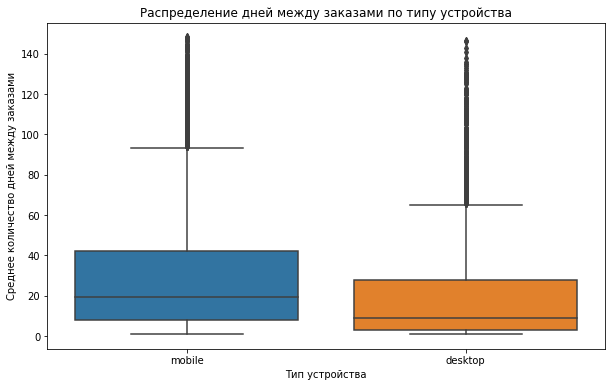

In [73]:


plt.figure(figsize=(10, 6))
sns.boxplot(data=user_stats, x='device_type_canonical', y='days_between')
plt.title('Распределение дней между заказами по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Среднее количество дней между заказами')
plt.show()

Вывод:
p-value = 0.00000< 0.05 означает, что нулевая гипотеза отвергается - у мобильных пользователей время между заказами больше.
Размер эффекта (d = 0.3) указывает на слабую практическую разницу. Но важно не забывать, что и размер выборок по пользователем различен. И если обратить внимание на медианные значения: мобильные - 19.2 и десктопные - 9.0, то становится понятно, что десктопные заказывают в 2 раза чаще!

<a class='anchor' id="ch5"></a>
## 5. Итоговый вывод и рекомендации

**Информация о данных**

Период анализа: июнь–октябрь 2024 года.

Объём данных:

- 290 849 заказов
- 22 427 мероприятий
- 18 658 уникальных пользователей.

География: данные по регионам России и партнёрским сетям.


***Общий анализ данных***

**Наиболее востребованные мероприятия:**

- Концерты (39% всех заказов, 110 263 билета)

- Театры (23.6%, 66 664 билета)

- Категория "Другое" (22.7%, 64 053 билета)

**Изменение популярности мероприятий осенью**

Спортивные мероприятия осенью стали в 4 раза популярнее, чем летом (11.2% против 2.6%).
Наблюдается парадокс: рост спроса осенью сопровождается снижением средней цены билета на 10-18% для ключевых категорий. Исключение: стендап (+5.9%) и выставки (+4.9%) показали рост цен при увеличении спроса. Концерты упали в цене на 10.9% при максимальном объеме продаж. Неплохо бы исследовать причины.

В целом, в разрезе сезона наблюдается следующее:

*Рост спроса:*

- Спорт: +330% (с 2.6% до 11.2% от всех заказов)

- Театры: +23% (с 20.7% до 25.6%)

- Семейные мероприятия (0+ и 6+): рост на 5-10%

*Спад спроса:*

- Концерты: -10% (с 41.4% до 37.3%)

- Категория "Другое": -30% (с 27.6% до 19.3%)

- Стендап: -11% (с 8.8% до 7.8%)


В данных наблюдается четкий сезонный рост количества заказов с сентября. Пик приходится на октябрь (в 3р. больше чем в июне).В целом, осенью наблюдается скачок по всем мероприятиям. Наиболее незначительные изменения наблюдаются в стендапе, значительный скачок в покупках наблюдается в категории спорт и театр.

Количество заказов осенью больше в первой половине недели, в отличия от лета.
А вот средний чек в первую половину ниже, видимо есть какая-то промо акция, которая дает скидки по будням.

Наблюдается осенний рост спроса на семейные мероприятий и категории 12+. Снижение спроса на "взрослые" мероприятия (18+, 21+). И осенью и летом наиболее распространенная категория - 16+.

Успешный запуск новых площадок ("Платформа" и "Светлячок"). Проблемы у части площадок ("Вдох" - полное прекращение продаж)

**Изменение среднего чека**

*Снижение среднего чека осенью:*

- Концерты: -7.9% (с 290 до 267 руб.)

- Театры: -17.8% (с 214 до 176 руб.)

- Ёлки: -15.4% (с 271 до 230 руб.)

*Рост среднего чека:*

- Стендап: +5.8% (с 218 до 231 руб.)

- Выставки: +4.8% (с 86 до 91 руб.)

Возможно, осенью проводятся акции и скидки на массовые мероприятия (концерты, театры), а нишевые события (стендап, выставки) становятся дороже из-за повышенного спроса.



**Пользовательская активность**

- Мобильные пользователи (80% заказов) покупают чаще, но с меньшим средним чеком (-4.5% vs десктоп).

- Десктоп-пользователи (20% заказов) совершают более дорогие покупки, но реже.

- Осенью активность растет:

    - На 35-40% больше заказов, чем летом.

    - Семейная аудитория (0+, 6+, 12+) покупает в 2 раза чаще.

- Недельная цикличность:

    - Выходные – пик продаж.

    - Будни – ниже спрос, но выше средний чек (возможно, корпоративные заказы).

Мобильные приложения в стравнении с десктопными имеют в 2.8x больше заказов, на 28% выше конверсия (12.6 vs 8.2 заказов/пользователя), но средний чек на у них ниже. Десктоп-аудитория, вероятно совершает меньше импульсивных покупок. 

**Лидеры среди регионов и партнеров**
*Регионы-лидеры:*
- Каменевский регион – 38.7% выручки (55.9 млн руб., 89 593 заказа).

- Североярская область – 15.3% выручки (22.1 млн руб., 43 737 заказов).

- Озернинский край – 6.5% выручки (9.4 млн руб., 10 348 заказов).

Вывод: 2 региона дают 54% выручки – это ключевые точки роста.

*Партнёры-лидеры:*
- "Билеты без проблем" – 18.6% заказов (31 105 шт.), но низкий средний чек (378 руб.).

- "Мой билет" – 13.1% выручки (10.7 млн руб.), высокий средний чек (560 руб.).

- "Облачко" – 13.1% выручки (10.6 млн руб.), баланс объема и цены.

*Премиальные партнёры:*

- "Край билетов" – рекордный средний чек (1 007 руб.), но мало заказов.

- "Весь в билетах" – 15 567 руб. выручки на мероприятие (в 5x выше среднего).

Вывод: Есть явные лидеры, но некоторые партнёры недоиспользуют потенциал (например, "Край билетов" мог бы продавать больше).

**Рекомендации:**
- Усилить продвижение в Каменевском регионе и Североярской области т.к. они приносят наибольшую выручку.
- Разработать программы лояльности для десктопных пользователей
- Возможно сделать сезонные акции для семейной аудитории (сентябрь-октябрь), хотя возможно именно из-за них произошло падение выручки
- Исследовать причины падения цен на концерты и театры
- Рассмотреть динамическое ценообразование для популярных мероприятий
- Детализировать категорию "Другое", т.к. не совсем понятно из чего она состоит. Ограниченна ли она возрастными рамками?
- Увеличить долю стендап-мероприятий, потому что наблюдается рост цен и стабильный спрос
- Изучить с чем связан успех Студии дизайна "Платформа" Инкорпорейтед  для использования и переноса опыта на другие площадки.

**Результат проверки гипотез по мобильным и стационарным устройствам**

Основные результаты:

- Мобильные пользователи делают в среднем чуть больше заказов ( но и выборка по этим пользователям больше)
- Десктопные пользователи делают заказов в 2 раза чаще, чем мобильные пользователи. 

Проблемы данных:

- Ненормальные распределения временных метрик
- Большая диспропорция в размерах групп (5:1)
- Наличие аномальных значений 



***Итоговые рекомендации и выводы***

- Концерты и театры – самые популярные, но осенью их выручка падает из-за снижения цен.

- Спорт и семейные мероприятия резко растут осенью.

- Мобильные пользователи – ключевая аудитория, но десктоп приносит больше денег.

- Каменевский регион и "Билеты без проблем" – главные драйверы продаж.

**Рекомендации:**

- Повысить средний чек и определить с чем связано его снижение.
- Обратить внимание, почему несмотря на большую аудиторию мобильных пользователей в сравнению с десктопными, они в два раза реже делают заказы.
- Унифицировать пользовательский опыт
- Ввести персонализированные скидки для десктоп-пользователей (их средний чек выше)
- Необходимо разобраться почему мобильные пользователи заказывают в 2 раза реже, возможно, стоит модифицировать интерфейс и способы оплаты  через мобильную версию.

Доработка аналитики:
- Внедрить когортный анализ вместо сравнения платформ
- Отслеживать LTV (пожизненную ценность) пользователей
- определить с чем связаны крупные покупки, возможно необходимо составить персональные предложения для крупных покупателей для их удержания.
- определить мотивации повторных покупок
- Исследовать причины аномально долгих интервалов между заказами у части пользователей

